# **Trabajo de fin de Máster: Categorización de miopías**

### **Anexo 2: Predicción de estructuras oculares mediante redes PINN**

##### *Por Juan Carlos Velasco Sánchez, Rubén Casal Ferrero y Manuel García González*

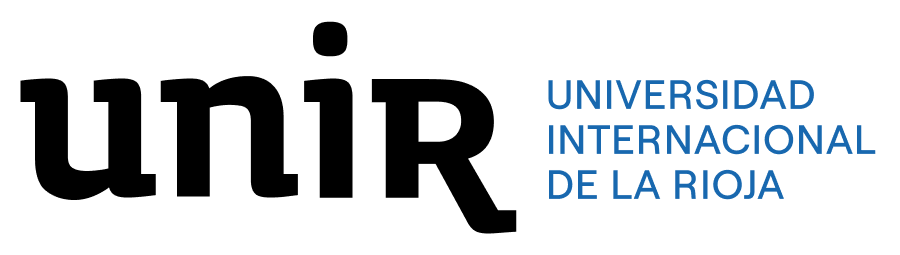

El segundo anexo corresponde al desarrollo del modelo predictivo basado en redes neuronales informadas por la física (PINNs), orientado a la estimación de parámetros biométricos clave del ojo humano a partir de variables más accesibles. Este enfoque busca predecir estructuras como la longitud axial del ojo (AXL), el grosor del cristalino (LENS), la paquimetría corneal (Paq), el radio de curvatura corneal anterior (RaK) y la profundidad de la cámara anterior (ACD), a partir de características demográficas y oftalmológicas disponibles en la práctica clínica, como la edad, el sexo, la constante quirúrgica, la superficie anterior (SA), el volumen (V) y la dioptría.

El notebook comienza con la limpieza y transformación del dataset, junto con el el cálculo y etiquetado de las dioptrías esperadas según el modelo implementado. Posteriormente se define la arquitectura del modelo PINN, el cual incorpora una función de pérdida dual: una pérdida de datos convencional que evalúa el error entre las predicciones y los datos reales, y una pérdida física que penaliza incoherencias entre las estructuras estimadas y la dioptría calculada según el modelo de Le Grand.

Finalmente, se entrena y valida el modelo sobre un conjunto de pacientes reales, evaluando el rendimiento predictivo de cada una de las estructuras mediante métricas.

--------------------------------------------------------

Importaciones necesarias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.optimize import root_scalar, minimize
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


--------------------------------------------------------

## Paso 1. Calculo del error refractivo de los pacientes
Por cada paciente, se añade una nueva columna al conjunto de datos con la potencia de la lente necesaria para corregir su ametropía. Para realizar este cálculo se usa el modelo teórico de LeGrand.

--------------------------------------------------------

In [2]:
#Constantes del modelo de LeGrand
parametros = {
    'R1': 0.0078,
    'R2': 0.0065,
    'R3': 0.0102,
    'R4': -0.0060,
    'e_cornea': 0.55e-3,
    'camara_ant': 3.6e-3,
    'e_lente': 4e-3,
    'longitud_axial': 0.024,
    'n_cornea': 1.3771,
    'n_acuoso': 1.3374,
    'n_cristalino': 1.42,
    'n_vitreo': 1.336
}

--------------------------------------------------------
Esta función permite obtener la potencia de la lente necesaria para corregir la ametropía de un ojo mediante una aproximación donde se calcula el índice de refracción general del ojo, a partir únicamente de su longitud axial. Esta fórmula no se usa en este notebook.

--------------------------------------------------------

In [3]:
def calcular_potencia(axlMM):
    # le GRAND
    axl_lg_MM = 24.2
    n_aire = 1

    # Convertir a metros
    axl_lg_M = axl_lg_MM / 1000
    axlM = axlMM / 1000

    # Potencia total teórica de Le Grand calculada con dos superficies
    potencia_total_teorica = 59.94

    #formula de la potencia = n_ojo - n_aire / axl --> despejar el indice de refracción del ojo
    n_ojo = (potencia_total_teorica * axl_lg_M) + n_aire

    p_paciente = (n_ojo - n_aire) / axlM

    #Diferencia entre la potencia del paciente y la potencia teórica
    dif = p_paciente - potencia_total_teorica
    return dif


--------------------------------------------------------
La siguiente función permite obtener la potencia de la lente necesaria para corregir la ametropía de un ojo mediante el cálculo de las potencias de las estructuras del ojo. La función tiene como entrada la longitud axial, espesor del cristalino, espesor de la cornea, radio anterior de la córnea y distancia de la cámara anterior. Tomaremos como convenio que la lente se sitúa a 12mm del ojo.

--------------------------------------------------------

In [4]:
def distancia_imagen(n_final, P_total):
    return n_final / P_total

In [5]:
def potencia_superficie(n2, n1, R):
    return (n1 - n2) / R

In [6]:
def potencia_lente_correctora(P_ojo, P_deseada, d):
    return (P_deseada - P_ojo) / (1 - d * P_deseada)

In [7]:
d1 = 0.02229

In [8]:
def calc(param, AXL, espesorCristalino, espesorCornea, radioAnteriorCornea, acd):
    radioPosteriorCornea = radioAnteriorCornea * 0.822

    #Potencias superficiales
    Pcornea_anterior = potencia_superficie(1.000, param['n_cornea'], radioAnteriorCornea)
    Pcornea_posterior = potencia_superficie(param['n_cornea'], param['n_acuoso'], radioPosteriorCornea)
    Pcristalino_anterior = potencia_superficie(param['n_acuoso'], param['n_cristalino'], param['R3'])
    Pcristalino_posterior = potencia_superficie (param['n_cristalino'], param['n_vitreo'], param['R4'])

    #Potencia total
    Pcornea = Pcornea_anterior + Pcornea_posterior - (espesorCornea / param['n_cornea']) * Pcornea_anterior * Pcornea_posterior
    Pcristalino = Pcristalino_anterior + Pcristalino_posterior - (espesorCristalino / param['n_cristalino']) * Pcristalino_anterior * Pcristalino_posterior

    hc = espesorCornea * (param['n_cornea'] - 1) / Pcornea
    hl = espesorCristalino * (param['n_cristalino'] - param['n_acuoso']) / Pcristalino
    dist1 = acd - hc + hl

    P_total_2S = Pcornea + Pcristalino - (dist1 / param['n_acuoso']) * Pcornea * Pcristalino

    distancia_lente_correctora = 0.0012

    d1 = AXL - (1.91 / 1000)

    # Potencia deseada para enfocar en la retina
    P_deseada = param['n_vitreo'] / d1

    # Potencia de la lente correctora (d = distancia desde la lente a la retina)
    d = distancia_lente_correctora  # en metros
    P_lente = potencia_lente_correctora(P_total_2S, P_deseada, d)

    return P_lente

--------------------------------------------------------
Una vez definida la función, se procede a cargar el dataset y añadir la nueva columna con la potencia de la lente calculada para cada paciente.

--------------------------------------------------------

In [9]:
# cargamos el dataset
data = pd.DataFrame(pd.read_excel("Base Datos Pacientes.xlsx"))
data.head()

,Sexo,F. Nac,F. Ex.,Días,Edad años,OD/OI,AXL,ACD,LENS,Paq,...,K1,Eje K1,K2,Eje K2,Cil,Eje,Km,RaK,SA,V
0,H,1934-12-11,2016-04-26 00:00:00,29295,81.375000,OD,23.30,3.34,4.21,0.570,...,44.09,76,44.84,166,-0.75,76,44.465,7.590240,7.55,15.75
1,H',1934-12-11,2016-04-26 00:00:00,29295,81.375000,OI,23.09,3.27,4.37,0.573,...,44.43,86,45.83,176,-1.40,86,45.130,7.478396,7.64,15.45
2,M,1931-06-16,2016-10-06 00:00:00,30710,85.305556,OD,21.86,2.92,5.21,0.607,...,45.47,143,45.73,53,-0.26,143,45.600,7.401316,8.13,13.73
3,M',1931-06-16,2016-10-06 00:00:00,30710,85.305556,OI,21.72,2.85,5.16,0.588,...,45.60,84,46.58,174,-0.98,84,46.090,7.322630,8.01,13.71
4,M,1947-05-08,2016-11-29 00:00:00,25041,69.558333,OD,21.44,2.43,5.30,0.552,...,44.64,162,44.97,72,-0.33,162,44.805,7.532641,7.73,13.71


In [10]:
# Añadimos nueva columna, con el valores de las dioptrias de cada paciente
data["Dioptrias"] = data.apply(
    lambda row: calc(parametros, (row['AXL'] / 1000), (row['LENS'] / 1000), (row['Paq'] / 1000), (row['RaK'] / 1000), (row['ACD'] / 1000)),
    axis=1
)
data.head()

,Sexo,F. Nac,F. Ex.,Días,Edad años,OD/OI,AXL,ACD,LENS,Paq,...,Eje K1,K2,Eje K2,Cil,Eje,Km,RaK,SA,V,Dioptrias
0,H,1934-12-11,2016-04-26 00:00:00,29295,81.375000,OD,23.30,3.34,4.21,0.570,...,76,44.84,166,-0.75,76,44.465,7.590240,7.55,15.75,-0.414747
1,H',1934-12-11,2016-04-26 00:00:00,29295,81.375000,OI,23.09,3.27,4.37,0.573,...,86,45.83,176,-1.40,86,45.130,7.478396,7.64,15.45,-0.454049
2,M,1931-06-16,2016-10-06 00:00:00,30710,85.305556,OD,21.86,2.92,5.21,0.607,...,143,45.73,53,-0.26,143,45.600,7.401316,8.13,13.73,3.082137
3,M',1931-06-16,2016-10-06 00:00:00,30710,85.305556,OI,21.72,2.85,5.16,0.588,...,84,46.58,174,-0.98,84,46.090,7.322630,8.01,13.71,3.046329
4,M,1947-05-08,2016-11-29 00:00:00,25041,69.558333,OD,21.44,2.43,5.30,0.552,...,162,44.97,72,-0.33,162,44.805,7.532641,7.73,13.71,5.107971


--------------------------------------------------------
## Paso 2. Preparación del dataset.
En esta fase se explorará el dataset para ver qué datos se tienen, y aplicar las transformaciones necesarias para construir un modelo adecuado al objetivo.

--------------------------------------------------------

In [11]:
#Columnas del dataset
data.columns

Index(['Sexo', 'F. Nac', 'F. Ex.', 'Días', 'Edad años', 'OD/OI', 'AXL', 'ACD',
       'LENS', 'Paq', 'CW', 'K1', 'Eje K1', 'K2', 'Eje K2', 'Cil', 'Eje', 'Km',
       'RaK', 'SA', 'V', 'Dioptrias'],
      dtype='object')

In [12]:
#Estadísticos
print(data.describe())

                              F. Nac          Días    Edad años          AXL  \
count                           1483   1483.000000  1483.000000  1483.000000   
mean   1940-11-06 12:10:11.732973696  27203.175320    75.564376    23.517736   
min              1916-03-28 00:00:00   8997.000000    24.991667    20.630000   
25%              1933-09-15 00:00:00  25147.500000    69.854167    22.670000   
50%              1939-05-20 00:00:00  27689.000000    76.913889    23.230000   
75%              1946-06-05 00:00:00  29749.500000    82.637500    23.990000   
max              1991-03-17 00:00:00  36000.000000   100.000000    33.740000   
std                              NaN   3460.435558     9.612321     1.488427   

               ACD         LENS          Paq           CW           K1  \
count  1483.000000  1483.000000  1483.000000  1483.000000  1483.000000   
mean      3.156906     4.620762     0.543053    11.485496    43.913722   
min       1.610000     3.260000     0.415000    10.350000

In [13]:
#Comprobación de nulos
print(data.isnull().sum())

Sexo         0
F. Nac       0
F. Ex.       0
Días         0
Edad años    0
OD/OI        0
AXL          0
ACD          0
LENS         0
Paq          0
CW           0
K1           0
Eje K1       0
K2           0
Eje K2       0
Cil          0
Eje          0
Km           0
RaK          0
SA           0
V            0
Dioptrias    0
dtype: int64


In [14]:
#Comprobación de tipos
data.dtypes

,0
Sexo,object
F. Nac,datetime64[ns]
F. Ex.,object
Días,int64
Edad años,float64
OD/OI,object
AXL,float64
ACD,float64
LENS,float64
Paq,float64


--------------------------------------------------------

La variable Eje K2 es de tipo "object", se va a transformar a tipo numérico.

--------------------------------------------------------

In [15]:
#Convertir la columna Eje K2 a tipo numérico
data['Eje K2'] = pd.to_numeric(data['Eje K2'], errors='coerce')

#Eliminar filas con valores NaN
data.dropna(inplace=True)

--------------------------------------------------------
**Eliminar variables redundantes o innecesarias**: En el dataset, existen 3 columnas, "F. Nac", "Días" y "Edad años", que representan la edad del paciente de diferentes formas. Basta con quedarse con una de ellas y eliminar las otras dos.

Por otro lado, la variable "F .Ex" representa la fecha en la que se hizo el examen por parte del oftalmólogo, la cual no aporta información valiosa para el objetivo del proyecto.

--------------------------------------------------------

In [16]:
#Eliminar fecha de nacimiento y días ya que representa lo mismo que 'Edad años'
data.drop(columns=["F. Nac"], inplace=True)
data.drop(columns=["Días"], inplace=True)

#Eliminar la variable "F. Ex."
data.drop(columns=["F. Ex."], inplace=True)

--------------------------------------------------------
**Codificación de variables**: Se convierten las variables categóricas 'Sexo' y 'OD/OI' mediante One Hot Encoding de manera que el modelo pueda trabajar correctamente con ellas.

--------------------------------------------------------

In [17]:
#Codificar la columna sexo a valor numérico
data['Sexo'] = data['Sexo'].replace({'H': 0, 'H\'': 0, 'M': 1, 'M\'': 1})

#Codificar la columna OD/OI a valor numérico
data['OD/OI'] = data['OD/OI'].replace({'OD': 0, 'OI': 1})

/tmp/ipython-input-17-1126954568.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sexo'] = data['Sexo'].replace({'H': 0, 'H\'': 0, 'M': 1, 'M\'': 1})
/tmp/ipython-input-17-1126954568.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['OD/OI'] = data['OD/OI'].replace({'OD': 0, 'OI': 1})


--------------------------------------------------------
**Manejo de outliers**: Se van a buscar valores atípicos en los datos, que llenan de ruido el conjunto de datos y pueden perjudicar el rendimiento del modelo si son aportados al modelo para ser entrenado. Por ello, se buscan aquellos valores que están por debajo del límite inferior y por encima del límite superior que marcan los cuartiles Q1 y Q3.

--------------------------------------------------------

In [18]:
def clean_dataset(data):
    #No tiene mucho sentido buscar outliers en la edad
    not_available_columns = ['Edad años']

    cleaned_data = data.copy()
    for col in data.columns:
        if col in cleaned_data.columns:
            if cleaned_data[col].dtype in ['float64', 'int64'] and col not in not_available_columns:
                # Calcular cuartiles
                q1 = cleaned_data[col].quantile(0.25)
                q3 = cleaned_data[col].quantile(0.75)
                iqr = q3 - q1

                # Calcular límites
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr

                # Contar outliers antes de eliminar
                outliers_count = len(cleaned_data[(cleaned_data[col] < lower_bound) |
                                                (cleaned_data[col] > upper_bound)])

                # Filtrar outliers
                cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) &
                                          (cleaned_data[col] <= upper_bound)]

                print(f"Columna '{col}': Eliminados {outliers_count} outliers "
                      f"(límites: {lower_bound:.2f} - {upper_bound:.2f})")

    print(f"\nDataset original: {len(data)} filas")
    print(f"Dataset limpio: {len(cleaned_data)} filas")
    print(f"Filas eliminadas: {len(data) - len(cleaned_data)} ({(len(data) - len(cleaned_data))/len(data)*100:.1f}%)")
    return cleaned_data


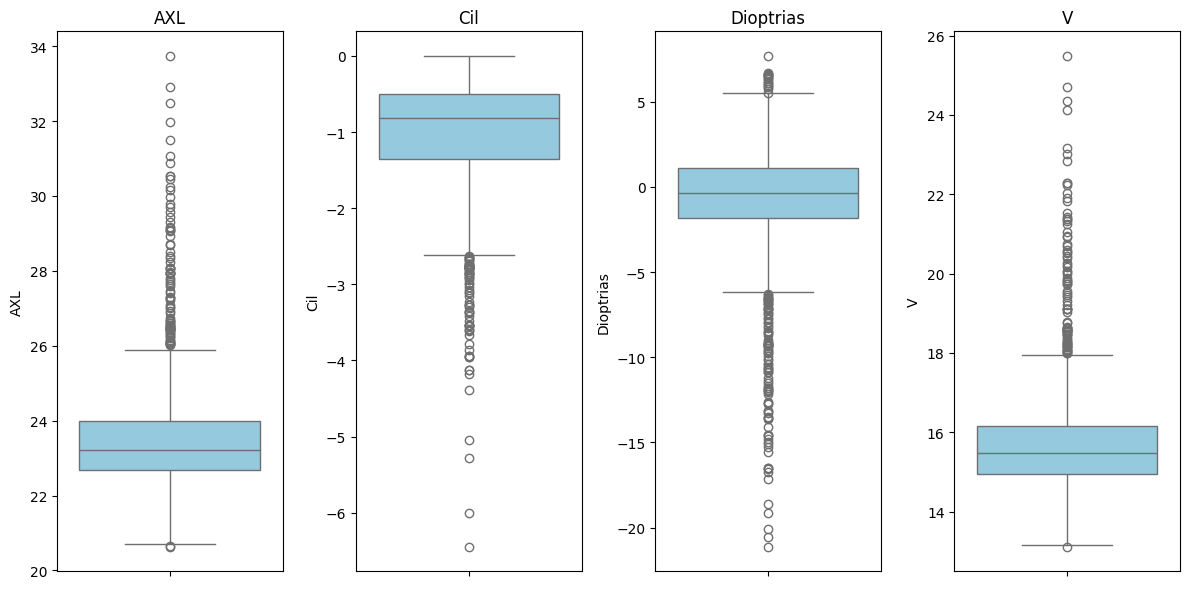

In [19]:
# Lista de columnas con más outliers a analizar
variables_con_outliers = ['AXL', 'Cil', 'Dioptrias', 'V']

# Tamaño del gráfico
plt.figure(figsize=(12, 6))

# Crear un subplot por variable
for i, col in enumerate(variables_con_outliers, 1):
    plt.subplot(1, len(variables_con_outliers), i)
    sns.boxplot(y=data[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.show()


--------------------------------------------------------
Las siguientes columnas son las que tienen más valores atípicos. Como se puede observan, existen múlitples valores que superan los "bigotes" de la gráfica. Para estos valores, dado que existen múltiples outliers, estos podrían ser tratados de una manera diferente al resto, pero por el momento, se ha optado por eliminar aquellas entradas del dataset que estén fuera de los límites establecidos por los cuartiles.

--------------------------------------------------------

In [20]:
#Eliminar outliers
not_cleaned_data = data
data = clean_dataset(data)

# from scipy.stats.mstats import winsorize

# df_winsorized = data.copy()

# for col in variables_con_outliers:
#     # Winsorizing al 1% por abajo y arriba (ajustable)
#     df_winsorized[col] = winsorize(data[col], limits=[0.01, 0.01])



Columna 'Sexo': Eliminados 0 outliers (límites: -1.50 - 2.50)
Columna 'OD/OI': Eliminados 0 outliers (límites: -1.50 - 2.50)
Columna 'AXL': Eliminados 91 outliers (límites: 20.69 - 25.97)
Columna 'ACD': Eliminados 5 outliers (límites: 2.03 - 4.22)
Columna 'LENS': Eliminados 14 outliers (límites: 3.48 - 5.77)
Columna 'Paq': Eliminados 6 outliers (límites: 0.45 - 0.63)
Columna 'CW': Eliminados 8 outliers (límites: 10.36 - 12.57)
Columna 'K1': Eliminados 12 outliers (límites: 39.86 - 48.05)
Columna 'Eje K1': Eliminados 1 outliers (límites: -122.62 - 268.38)
Columna 'K2': Eliminados 7 outliers (límites: 40.88 - 49.01)
Columna 'Eje K2': Eliminados 0 outliers (límites: -89.00 - 247.00)
Columna 'Cil': Eliminados 71 outliers (límites: -2.55 - 0.73)
Columna 'Eje': Eliminados 0 outliers (límites: -119.00 - 265.00)
Columna 'Km': Eliminados 0 outliers (límites: 40.56 - 48.30)
Columna 'RaK': Eliminados 3 outliers (límites: 6.94 - 8.26)
Columna 'SA': Eliminados 14 outliers (límites: 6.85 - 8.65)
Col

--------------------------------------------------------
**Correlación de variables**: Una vez se han tratado los outliers, se procede a ver la relación entre las diferentes variables del conjunto de datos.

--------------------------------------------------------

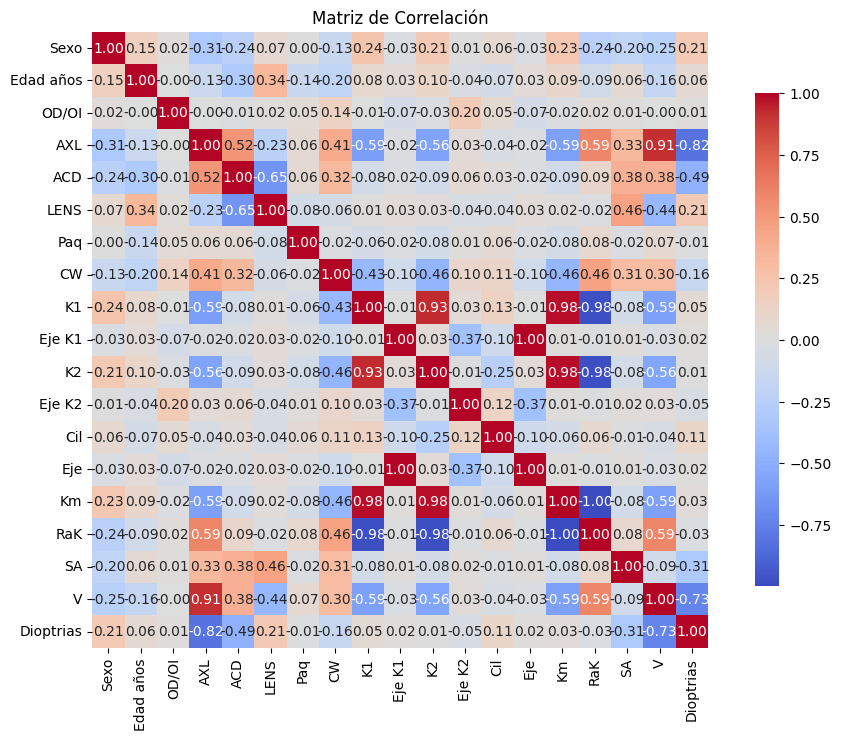

In [21]:
#Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

--------------------------------------------------------
**Eliminar variables correlacionadas**: Como se puede observar, existe varias variables con una correlación prácticamente perfecta. Es por ello que se va a eliminar varias variables, de manera que se reduce la dimensionalidad del conjunto de datos sin perder información relevante.

--------------------------------------------------------

In [22]:
#Eliminar K1 y K2 -> correlación de casi 1 con Km
data.drop(columns=["K1", "K2"], inplace=True)

#Eliminar Eje ó Eje K1 -> correlación de 1
data.drop(columns=["Eje"], inplace=True)

#Eliminar Km -> correlación de 1 con RaK
data.drop(columns=["Km"], inplace=True)

--------------------------------------------------------

Matriz de correlación con las variables limpiadas. La dimensionalidad del conjunto de datos ha pasado de 21 (más la columna introducida) a 15, manteniendo la misma información.

--------------------------------------------------------

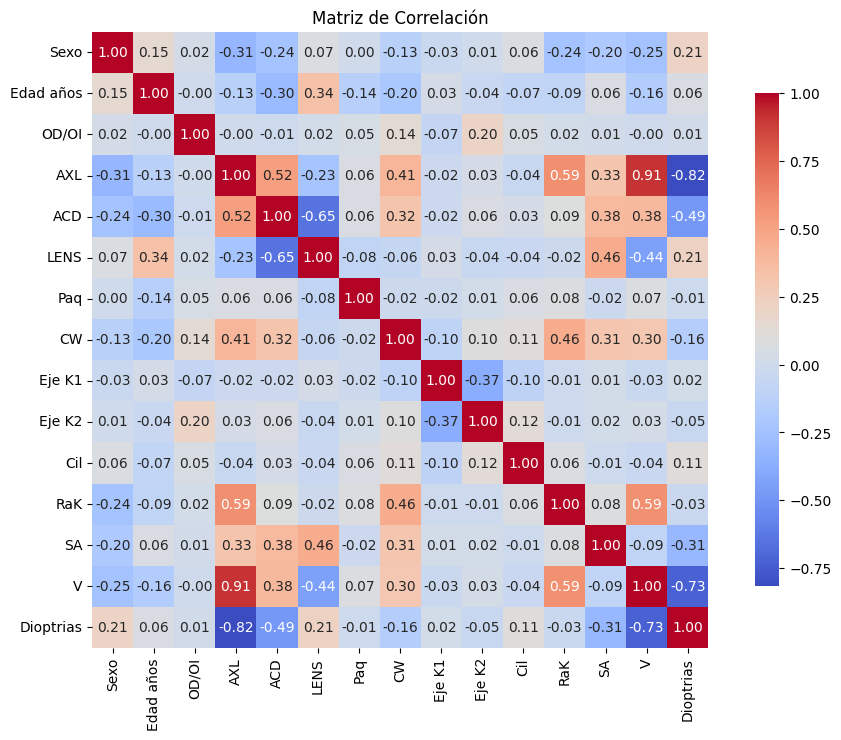

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()

--------------------------------------------------------
## Paso 3. Construcción del modelo

Se va implementar un modelo basado en redes neuronales, en concreto, un tipo de redes neuronales denominado PINN (Physics Informed Neural Networks), mediante la cual, a la red neuronal estándar se le añade una función física que guiará el entrenamiento teniendo un peso especificado en éste y que mantendrá los valores predichos por la red dentro del rango físico normal. En este modelo, a partir de la potencia de la lente calculada y otras variables, como la edad y el sexo, se pretende predecir el resto de las estructuras del ojo, que son las estructuras con las que se calculó esta potencia: longitud axial, grosor del cristalino, espesor de la córnea, radio anterior de la córnea y distancia de la cámara anterior.

--------------------------------------------------------

In [24]:
# Parámetros de entrada del modelo
parametros_entrada = ['CW', 'Edad años', 'Sexo', 'SA', 'V', 'Dioptrias']

In [25]:
# Definir parametros de salida de la red
parametros_target = ["AXL", "LENS", "Paq", "RaK", "ACD"]

In [26]:
X = data[parametros_entrada].values
y = data[parametros_target].values

--------------------------------------------------------
División de los datos. Se dividen los datos en tres tipos. Los datos de entrenamiento (60% de los datos), que sirven para entrenar el modelo; los datos de validación (16%), que permiten optimizar los hiperparámetros del modelo; y los datos de test (20%), que son datos que el modelo no utiliza y que se usarán para realizar predicciones, obtener métricas y visualizar resultados del modelo entrenado.

--------------------------------------------------------

In [27]:
# División en train, val y test (64%/16%/20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (764, 6), Val: (192, 6), Test: (240, 6)


--------------------------------------------------------
## Estructura de la red

### Inicialización del Modelo

```python
PINN_model(X_train, X_val, y_train, y_val, lambda_data=1.0, lambda_physics=0.7)
```

* **Normaliza internamente** `X` e `y` (Z-score con media y std del train).
* Define la arquitectura neuronal y el optimizador Adam.
* Inicializa diccionario `self.history` para registrar las pérdidas.

### Arquitectura de la Red

* Capas: [64, 128, 128, 64, 32, output_dim]
* Activación: `tanh` (ocultas), `linear` (salida)
* Dropout tras las capas 128 para regularización

---

### Métodos Principales

##### `call(features, training)`

* Forward pass de la red.

##### `calculo_error_refractivo_tensores(axl, lens, paq, rak, acd)`

* Aplica el modelo físico para calcular el error refractivo.

##### `total_loss(l_data, l_physics)`

* Combina las dos pérdidas: datos y física.

##### `train_step(x_scaled, y_scaled, x_orig)`

* Paso de entrenamiento:
  * Calcula `l_data`, `l_physics`, `total_loss`.
  * Aplica `GradientTape` y actualiza pesos.

##### `val_step(x_scaled, y_scaled, x_orig)`

* Paso de validación:
  * Mismo cálculo que `train_step` sin actualización de pesos.

##### `fit_PINN(num_epochs, print_every=100, save_path=..., patience=100)`

* Ejecuta entrenamiento durante `num_epochs`.
* Guarda el mejor modelo.
* Early stopping si no mejora la validación en `patience` épocas.
* Registra pérdidas en `self.history`.
* Devuelve `history`.

##### `plot_history()`

* Grafica la evolución de las pérdidas:
  * Total, Data Loss, Physics Loss.

---

#### Diccionario `self.history`

Registra las siguientes listas por época:

* `train_total`, `val_total`
* `train_data`, `val_data`
* `train_physics`, `val_physics`

---

#### Notas

* No requiere normalización externa.
* `y` debe contener: `[AXL, LENS, PAQ, RAK, ACD]`.
* `X` debe contener al final la `dioptría real`

--------------------------------------------------------

In [28]:
class PINN_model(tf.keras.Model):
    def __init__(self, X_train, X_val, y_train, y_val, lambda_data=1.0, lambda_physics=0.5, **kwargs):
        super(PINN_model, self).__init__(**kwargs)
        # Valores de ponderación del error PINNs
        self.lambda_data = lambda_data
        self.lambda_physics = lambda_physics

        # Datos con los que se va a realizar el entrenamiento
        self.X_train = tf.constant(X_train, dtype=tf.float32)
        self.X_val = tf.constant(X_val, dtype=tf.float32)
        self.y_train = tf.constant(y_train, dtype=tf.float32)
        self.y_val = tf.constant(y_val, dtype=tf.float32)

        # Normalización de los datos
        self.X_mean = tf.reduce_mean(self.X_train, axis=0)
        self.X_std = tf.math.reduce_std(self.X_train, axis=0)
        self.y_mean = tf.reduce_mean(self.y_train, axis=0)
        self.y_std = tf.math.reduce_std(self.y_train, axis=0)

        self.X_train_norm = (self.X_train - self.X_mean) / self.X_std
        self.X_val_norm = (self.X_val - self.X_mean) / self.X_std
        self.y_train_norm = (self.y_train - self.y_mean) / self.y_std
        self.y_val_norm = (self.y_val - self.y_mean) / self.y_std

        # Hiperparametros del entrenamiento
        self.learning_rate = 0.01
        self.optimizer = tf.keras.optimizers.Adagrad(learning_rate=self.learning_rate)
        self.activation = 'tanh'

        # Arquitectura de la red neuronal
        self.dense0 = layers.Dense(self.X_train.shape[1], activation=self.activation)
        self.dense1 = layers.Dense(128, activation=self.activation)
        self.dropout1 = layers.Dropout(0.3)
        self.dense2 = layers.Dense(128, activation=self.activation)
        self.dropout2 = layers.Dropout(0.3)
        self.dense3 = layers.Dense(64, activation=self.activation)
        self.dense4 = layers.Dense(32, activation=self.activation)
        self.output_layer = layers.Dense(self.y_train.shape[1])

        # Datos último entrenamiento
        self.history = {
            'train_total': [],
            'val_total': [],
            'train_data': [],
            'val_data': [],
            'train_physics': [],
            'val_physics': []
        }

    def call(self, features, training):
        x = self.dense0(features)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.output_layer(x)

    def calculo_error_refractivo_tensores(self, axl_tensor, lens_tensor, paq_tensor, rak_tensor, acd_tensor):
        """Calculo del error refractivo para modelo tensorflow"""
        radioPosteriorCornea = rak_tensor * 0.822

        #Potencias superficiales
        Pcornea_anterior = potencia_superficie(1.000, parametros['n_cornea'], rak_tensor)
        Pcornea_posterior = potencia_superficie(parametros['n_cornea'], parametros['n_acuoso'], radioPosteriorCornea)
        Pcristalino_anterior = potencia_superficie(parametros['n_acuoso'], parametros['n_cristalino'], parametros['R3'])
        Pcristalino_posterior = potencia_superficie (parametros['n_cristalino'], parametros['n_vitreo'], parametros['R4'])

        #Potencia total
        Pcornea = Pcornea_anterior + Pcornea_posterior - (paq_tensor / parametros['n_cornea']) * Pcornea_anterior * Pcornea_posterior
        Pcristalino = Pcristalino_anterior + Pcristalino_posterior - (lens_tensor / parametros['n_cristalino']) * Pcristalino_anterior * Pcristalino_posterior

        hc = paq_tensor * (parametros['n_cornea'] - 1) / Pcornea
        hl = lens_tensor * (parametros['n_cristalino'] - parametros['n_acuoso']) / Pcristalino
        dist1 = acd_tensor - hc + hl

        P_total_2S = Pcornea + Pcristalino - (dist1 / parametros['n_acuoso']) * Pcornea * Pcristalino


        distancia_lente_correctora = 0.0012
        d2 = axl_tensor - (1.91 / 1000)

        # Potencia deseada para enfocar en la retina
        P_deseada = parametros['n_vitreo'] / d2

        # Potencia de la lente correctora (d = distancia desde la lente a la retina)
        d = distancia_lente_correctora  # en metros
        P_lente = potencia_lente_correctora(P_total_2S, P_deseada, d)
        return P_lente

    def total_loss(self, l_data, l_physics):
        """Función de pérdidad total PINNs"""
        return self.lambda_data * l_data + self.lambda_physics * l_physics

    @tf.function
    def train_step(self, x_scaled, y_scaled, x_orig):
        """Función step del entrenamiento"""
        with tf.GradientTape() as tape:
            y_pred_scaled = self(x_scaled, training=True)
            l_data = tf.reduce_mean(tf.square(y_pred_scaled - y_scaled))

            y_pred_orig = y_pred_scaled * self.y_std + self.y_mean
            axl, lens, paq, rak, acd = [tf.squeeze(t) for t in tf.split(y_pred_orig, 5, axis=1)]
            dioptrias_real = tf.squeeze(x_orig[:, -1])  # Cambia -1 por el índice si no está al final

            error_refractivo = self.calculo_error_refractivo_tensores(axl / 1000, lens / 1000, paq / 1000, rak / 1000, acd / 1000)
            l_physics = tf.reduce_mean(tf.square(error_refractivo - dioptrias_real))

            total_loss = self.total_loss(l_data, l_physics)

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return total_loss, l_data, l_physics

    @tf.function
    def val_step(self, x_scaled, y_scaled, x_orig):
        """Paso de validación del entrenamiento"""
        y_pred_scaled = self(x_scaled, training=False)
        l_data_val = tf.reduce_mean(tf.square(y_pred_scaled - y_scaled))

        y_pred_orig = y_pred_scaled * self.y_std + self.y_mean
        axl, lens, paq, rak, acd = [tf.squeeze(t) for t in tf.split(y_pred_orig, 5, axis=1)]
        dioptrias_real = tf.squeeze(x_orig[:, -1])
        error_refractivo = self.calculo_error_refractivo_tensores(axl / 1000, lens / 1000, paq / 1000, rak / 1000, acd / 1000)
        l_physics_val = tf.reduce_mean(tf.square(error_refractivo - dioptrias_real))
        loss_val = self.total_loss(l_data_val, l_physics_val)
        return loss_val, l_data_val, l_physics_val

    def fit_PINN(self, num_epochs, print_every=100, save_path='best_model.weights.h5', patience=100):
        """Entrenamiento del modelo"""
        best_val_loss = float('inf')
        best_epoch = 0
        epochs_without_improvement = 0

        history = {
            'train_total': [],
            'val_total': [],
            'train_data': [],
            'val_data': [],
            'train_physics': [],
            'val_physics': []
        }

        for epoch in range(num_epochs):
            loss_train, l_data_train, l_physics_train = self.train_step(
                self.X_train_norm, self.y_train_norm, self.X_train
            )
            loss_val, l_data_val, l_physics_val = self.val_step(
                self.X_val_norm, self.y_val_norm, self.X_val
            )

            # Guardar historial
            history['train_total'].append(loss_train.numpy())
            history['val_total'].append(loss_val.numpy())
            history['train_data'].append(l_data_train.numpy())
            history['val_data'].append(l_data_val.numpy())
            history['train_physics'].append(l_physics_train.numpy())
            history['val_physics'].append(l_physics_val.numpy())

            if loss_val.numpy() < best_val_loss:
                best_val_loss = loss_val.numpy()
                best_epoch = epoch + 1
                self.save_weights(save_path)
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1}/{num_epochs} - Train: {loss_train:.4f} (Data: {l_data_train:.4f}, Physics: {l_physics_train:.4f}) | Val: {loss_val:.4f} (Data: {l_data_val:.4f}, Physics: {l_physics_val:.4f})")

            if epochs_without_improvement >= patience:
                print(f"Early stopping en la época {epoch+1} (no mejora en {patience} épocas).")
                break

        print(f"Entrenamiento finalizado. Mejor modelo en época {best_epoch} con pérdida de validación: {best_val_loss:.4f}")
        self.load_weights(save_path)
        self.history = history

        return history

    def plot_history(self):
        """ Función para graficar los resultados del último entrenamiento realizado"""
        if self.history is None or len(self.history['train_total']) == 0:
            print("No hay historial de entrenamiento disponible.")
            return

        epochs = range(1, len(self.history['train_total']) + 1)

        plt.figure(figsize=(18, 5))

        # Pérdida total
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.history['train_total'], label='Train Total Loss')
        plt.plot(epochs, self.history['val_total'], label='Val Total Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Total Loss")
        plt.legend()

        # Pérdida de datos
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.history['train_data'], label='Train Data Loss')
        plt.plot(epochs, self.history['val_data'], label='Val Data Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Data Loss")
        plt.legend()

        # Pérdida física
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.history['train_physics'], label='Train Physics Loss')
        plt.plot(epochs, self.history['val_physics'], label='Val Physics Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Physics Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()


--------------------------------------------------------
**Inicialización y entrenamiento del modelo**

--------------------------------------------------------

In [29]:
model = PINN_model(
    X_train, X_val,
    y_train, y_val,
    lambda_data=1,
    lambda_physics=0.7
)


In [30]:
history = model.fit_PINN(
    num_epochs=10000,
    print_every=100,  # Muestra progreso cada 100 epochs
    save_path='best_model.weights.h5',
    patience = 350
)

Epoch 100/10000 - Train: 0.8053 (Data: 0.6381, Physics: 0.2389) | Val: 0.6188 (Data: 0.5185, Physics: 0.1433)
Epoch 200/10000 - Train: 0.7067 (Data: 0.5847, Physics: 0.1742) | Val: 0.5606 (Data: 0.4848, Physics: 0.1084)
Epoch 300/10000 - Train: 0.6557 (Data: 0.5538, Physics: 0.1455) | Val: 0.5244 (Data: 0.4633, Physics: 0.0873)
Epoch 400/10000 - Train: 0.6161 (Data: 0.5293, Physics: 0.1241) | Val: 0.4991 (Data: 0.4480, Physics: 0.0730)
Epoch 500/10000 - Train: 0.6011 (Data: 0.5143, Physics: 0.1241) | Val: 0.4802 (Data: 0.4381, Physics: 0.0602)
Epoch 600/10000 - Train: 0.5725 (Data: 0.5017, Physics: 0.1012) | Val: 0.4671 (Data: 0.4308, Physics: 0.0519)
Epoch 700/10000 - Train: 0.5572 (Data: 0.4906, Physics: 0.0951) | Val: 0.4555 (Data: 0.4253, Physics: 0.0432)
Epoch 800/10000 - Train: 0.5513 (Data: 0.4845, Physics: 0.0954) | Val: 0.4475 (Data: 0.4213, Physics: 0.0374)
Epoch 900/10000 - Train: 0.5489 (Data: 0.4884, Physics: 0.0864) | Val: 0.4439 (Data: 0.4185, Physics: 0.0362)
Epoch 1000

--------------------------------------------------------
**Gráficas del entrenamiento del modelo**

--------------------------------------------------------

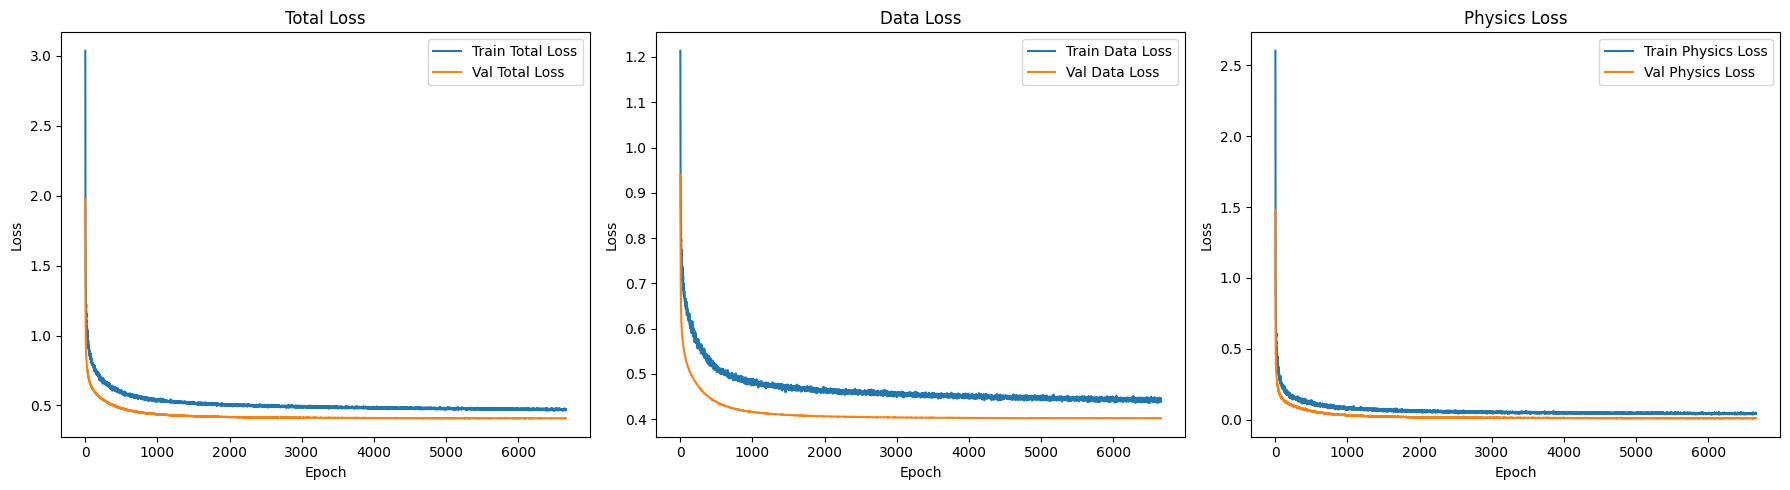

In [31]:
model.plot_history()

--------------------------------------------------------
## Paso 4. Evaluación del modelo entrenado.
Una vez se tiene un modelo, es hora de probar su rendimiento. Para ello, se usan los datos de test que se obtuvieron al dividir los datos, y se comparan los valores reales con respecto a los predichos, obteniendo así el error de las predicciones.

## Obtención del R² en el conjunto de test.
El R² es una métrica importante que muestra el grado de explicabilidad que consigue el modelo en sus predicciones.

--------------------------------------------------------


R² scores en conjunto de test:
AXL: 0.994
LENS: 0.442
Paq: 0.019
RaK: 0.968
ACD: 0.454
Promedio: 0.575


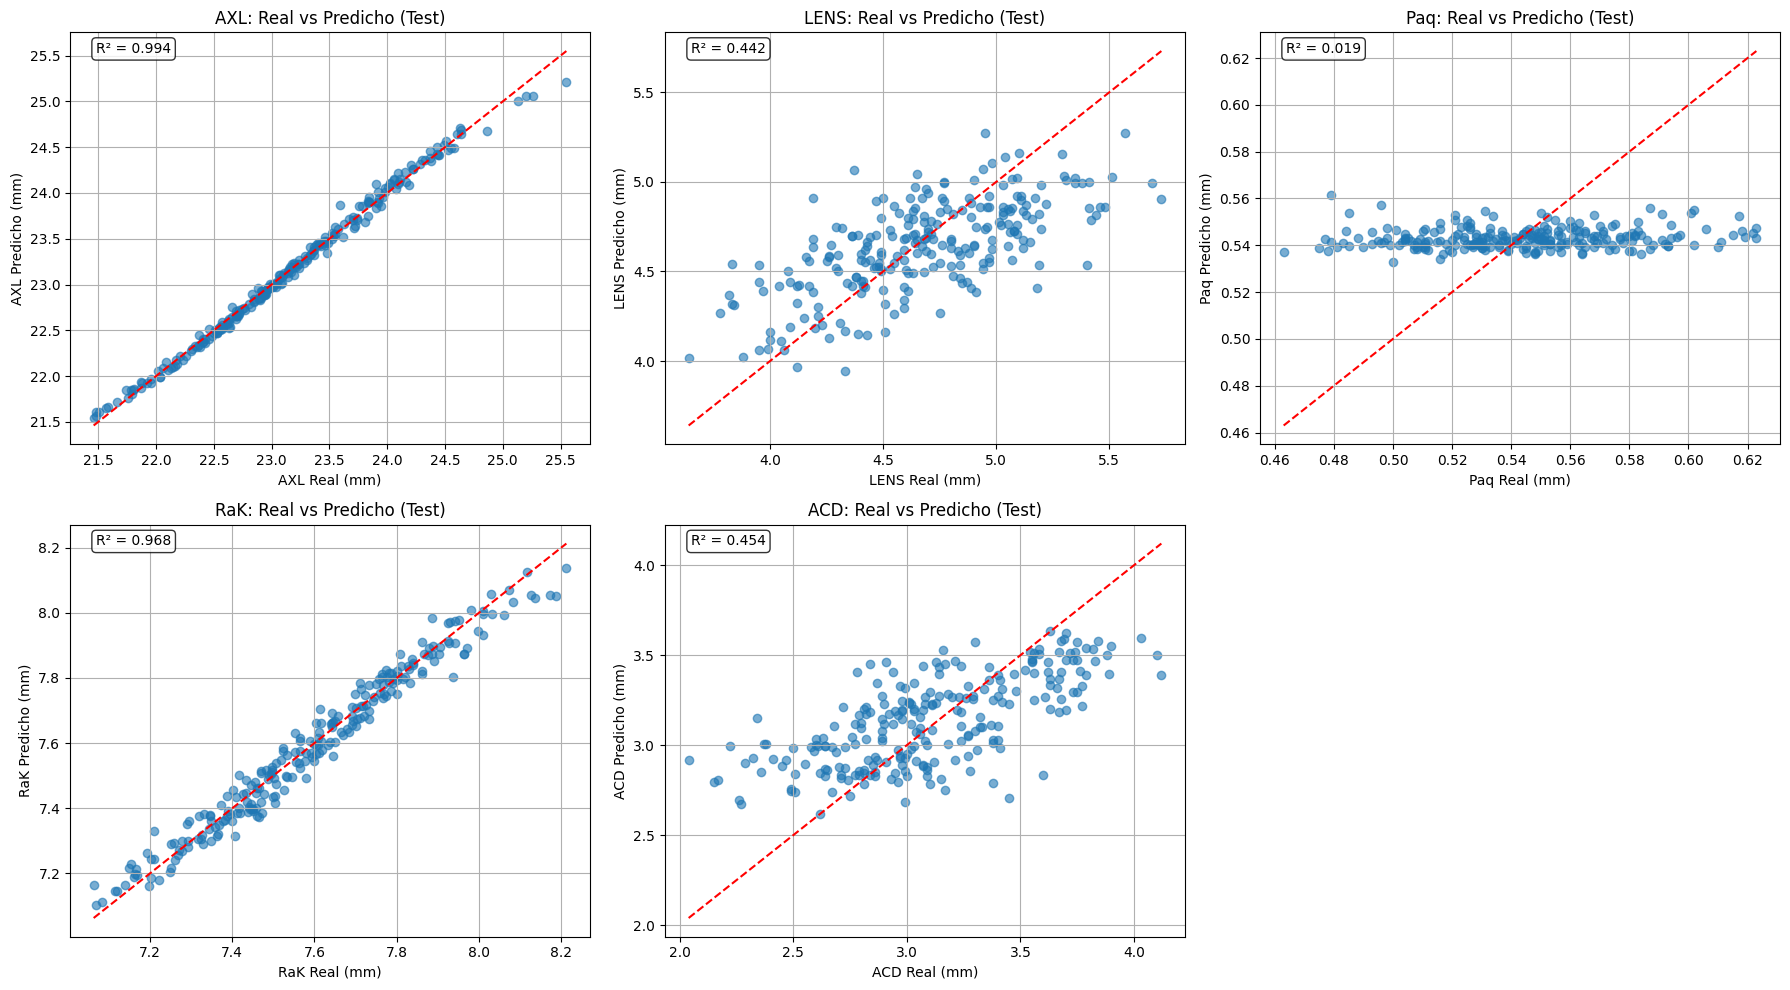

In [33]:
# Normalizar X_test con la media y std del entrenamiento
X_test_norm = (X_test - model.X_mean.numpy()) / model.X_std.numpy()
X_test_norm_tf = tf.constant(X_test_norm, dtype=tf.float32)
y_test_tf = tf.constant(y_test, dtype=tf.float32)

# Predicción sobre test
parametros_predichos_norm = model(X_test_norm_tf, training=False)
parametros_predichos = parametros_predichos_norm * model.y_std + model.y_mean

# Convertir a numpy para visualización
parametros_predichos_np = parametros_predichos.numpy()
parametros_test_np = y_test_tf.numpy()

feature_names = ['AXL', 'LENS', 'Paq', 'RaK', 'ACD']

print("\nR² scores en conjunto de test:")
r2_scores = []
for i, nombre in enumerate(feature_names):
    r2 = r2_score(parametros_test_np[:, i], parametros_predichos_np[:, i])
    r2_scores.append(r2)
    print(f"{nombre}: {r2:.3f}")
print(f"Promedio: {np.mean(r2_scores):.3f}")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes = axes.flatten()

for i, nombre in enumerate(feature_names):
    axes[i].scatter(parametros_test_np[:, i], parametros_predichos_np[:, i], alpha=0.6)
    axes[i].plot([parametros_test_np[:, i].min(), parametros_test_np[:, i].max()],
                 [parametros_test_np[:, i].min(), parametros_test_np[:, i].max()], 'r--')
    axes[i].set_xlabel(f'{nombre} Real (mm)')
    axes[i].set_ylabel(f'{nombre} Predicho (mm)')
    axes[i].set_title(f'{nombre}: Real vs Predicho (Test)')
    axes[i].grid(True)
    r2 = r2_score(parametros_test_np[:, i], parametros_predichos_np[:, i])
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

--------------------------------------------------------
**Gráfico de distribución de errores en los datos de test.**

--------------------------------------------------------

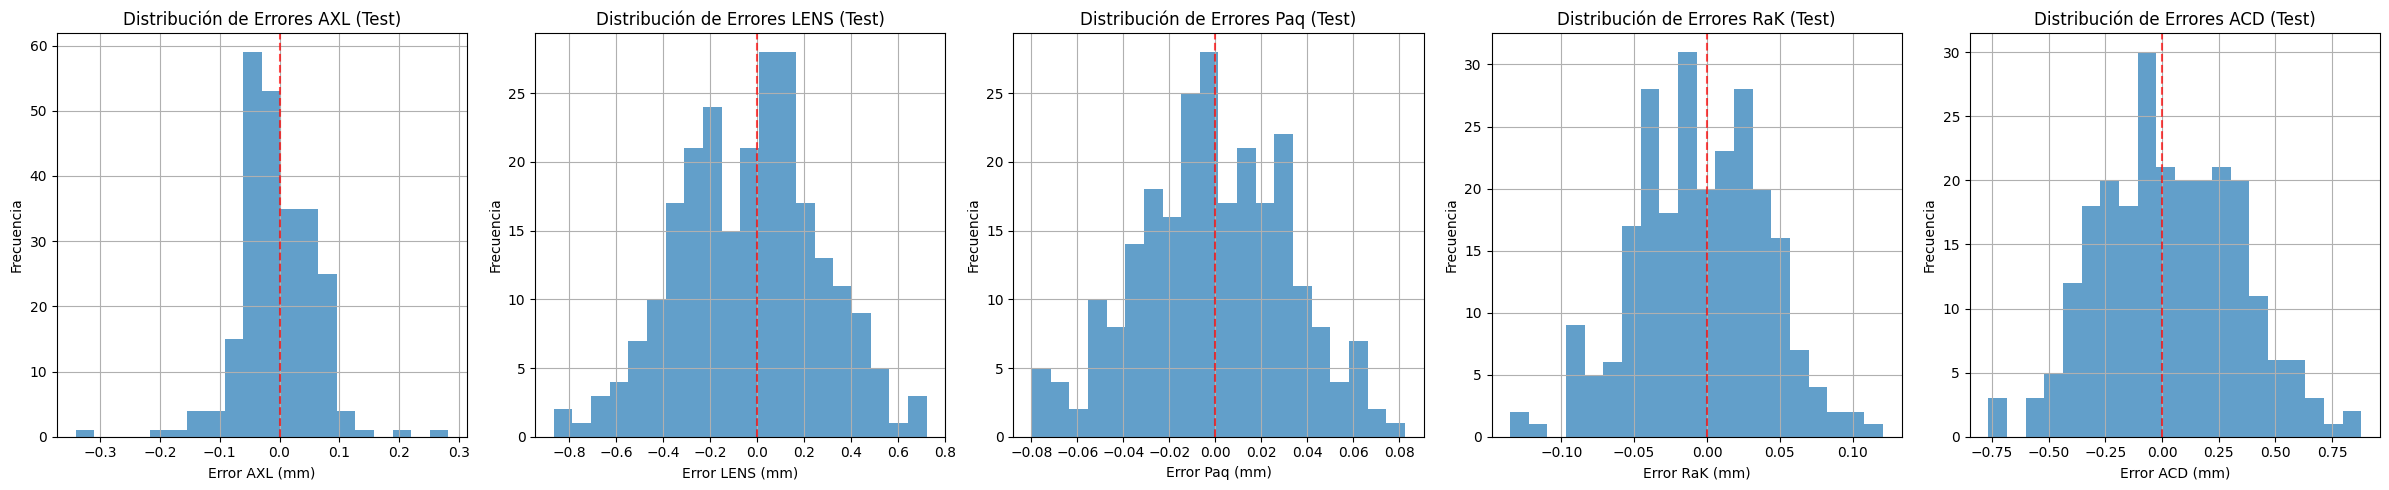

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(24, 5))
errores = parametros_predichos_np - parametros_test_np

for i, nombre in enumerate(feature_names):
    axes[i].hist(errores[:, i], bins=20, alpha=0.7)
    axes[i].set_xlabel(f'Error {nombre} (mm)')
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de Errores {nombre} (Test)')
    axes[i].grid(True)
    axes[i].axvline(0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

--------------------------------------------------------
**Gráfico de correlación entre cada variable predicha del modelo con las variables de entrada.**

--------------------------------------------------------

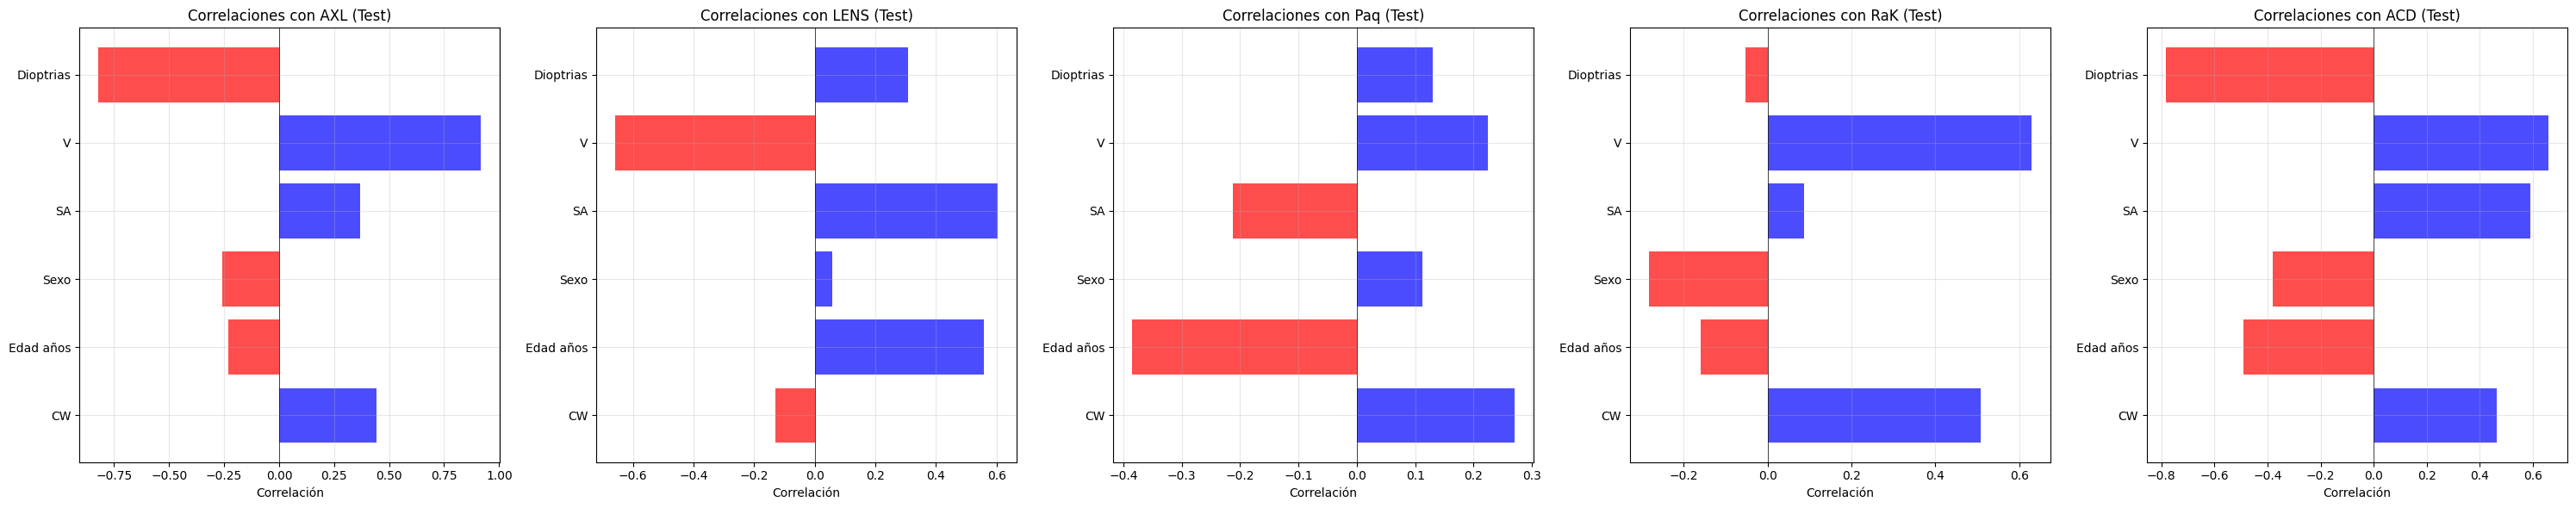

In [35]:
# Convertir features_val a numpy
features_test_np = X_test  # X_test ya es numpy array
parametros_predichos_np = parametros_predichos.numpy() if hasattr(parametros_predichos, 'numpy') else parametros_predichos

fig, axes = plt.subplots(1, len(feature_names), figsize=(30, 6))

for i, param_name in enumerate(feature_names):
    correlations = []
    for j, feat_name in enumerate(parametros_entrada):
        corr_matrix = np.corrcoef(features_test_np[:, j], parametros_predichos_np[:, i])
        corr = corr_matrix[0, 1]
        correlations.append(corr)

    y_pos = np.arange(len(parametros_entrada))
    colors = ['red' if x < 0 else 'blue' for x in correlations]

    axes[i].barh(y_pos, correlations, color=colors, alpha=0.7)
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(parametros_entrada)
    axes[i].set_xlabel('Correlación')
    axes[i].set_title(f'Correlaciones con {param_name} (Test)')
    axes[i].grid(True, alpha=0.3)
    axes[i].axvline(0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

--------------------------------------------------------
**Además del R² se pueden obtener otras métricas propias de problemas de regresión.**

--------------------------------------------------------


In [36]:
def evaluar_modelo_PINN(model, X_test, y_test, feature_names=None, verbose=True):
    """
    Evalúa el modelo PINN sobre el conjunto de test y muestra métricas de regresión para cada parámetro.
    """
    # Normalizar X_test con la media y std del entrenamiento
    X_test_norm = (X_test - model.X_mean.numpy()) / model.X_std.numpy()
    X_test_norm_tf = tf.constant(X_test_norm, dtype=tf.float32)
    y_test_np = y_test if isinstance(y_test, np.ndarray) else y_test.numpy()

    # Predicción sobre test
    y_pred_norm = model(X_test_norm_tf, training=False)
    y_pred = y_pred_norm * model.y_std + model.y_mean
    y_pred_np = y_pred.numpy()

    if feature_names is None:
        feature_names = [f'Var_{i+1}' for i in range(y_pred_np.shape[1])]

    resultados = {}
    for i, nombre in enumerate(feature_names):
        mae = mean_absolute_error(y_test_np[:, i], y_pred_np[:, i])
        mse = mean_squared_error(y_test_np[:, i], y_pred_np[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_np[:, i], y_pred_np[:, i])
        resultados[nombre] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }
        if verbose:
            print(f"\nMétricas para {nombre}:")
            print(f"  MAE  = {mae:.4f}")
            print(f"  MSE  = {mse:.4f}")
            print(f"  RMSE = {rmse:.4f}")
            print(f"  R²   = {r2:.4f}")
    return resultados

resultados = evaluar_modelo_PINN(model, X_test, y_test, feature_names)


Métricas para AXL:
  MAE  = 0.0473
  MSE  = 0.0040
  RMSE = 0.0635
  R²   = 0.9939

Métricas para LENS:
  MAE  = 0.2426
  MSE  = 0.0905
  RMSE = 0.3008
  R²   = 0.4416

Métricas para Paq:
  MAE  = 0.0263
  MSE  = 0.0011
  RMSE = 0.0327
  R²   = 0.0186

Métricas para RaK:
  MAE  = 0.0360
  MSE  = 0.0020
  RMSE = 0.0445
  R²   = 0.9683

Métricas para ACD:
  MAE  = 0.2507
  MSE  = 0.0952
  RMSE = 0.3085
  R²   = 0.4542


--------------------------------------------------------
## Paso 5. Análisis de resultados

En esta fase se van a analizar los resultados del modelo de manera global y cómo se pueden aplicar individualmente a cada paciente

#### Análisis de sensibilidad local: ¿Qué estructura influye más en la emetropía de cada ojo?

A continuación se calcula, para cada paciente del conjunto de test, ver cúal es la influencia de cada estructura con respecto a las dioptrías de la lente, esto es, la sensibilidad de las estructuras del ojo de los paciente. Para ello, se ha calculado de 3 formas diferentes.

La primera utiliza autograd de TensorFlow para obtener el gradiente de la función física respecto a cada parámetro predicho. El valor absoluto del gradiente indica la influencia local de cada estructura en el error refractivo de ese paciente.

--------------------------------------------------------

Sensibilidad media (absoluta) del error refractivo respecto a cada estructura en validación:


,AXL,LENS,Paq,RaK,ACD
Sensibilidad media,3.219334,0.080493,0.243034,5.911343,0.764373


Paciente 1: estructura más influyente = RaK
  Sensibilidades: {'AXL': np.float32(3.546188), 'LENS': np.float32(0.081515335), 'Paq': np.float32(0.24310265), 'RaK': np.float32(5.9124165), 'ACD': np.float32(0.7645277)}
Paciente 2: estructura más influyente = RaK
  Sensibilidades: {'AXL': np.float32(2.846877), 'LENS': np.float32(0.07936867), 'Paq': np.float32(0.23097433), 'RaK': np.float32(5.609584), 'ACD': np.float32(0.7467717)}
Paciente 3: estructura más influyente = RaK
  Sensibilidades: {'AXL': np.float32(2.7602525), 'LENS': np.float32(0.07915211), 'Paq': np.float32(0.2281386), 'RaK': np.float32(5.538902), 'ACD': np.float32(0.74102646)}
Paciente 4: estructura más influyente = RaK
  Sensibilidades: {'AXL': np.float32(3.4034066), 'LENS': np.float32(0.08019462), 'Paq': np.float32(0.26575986), 'RaK': np.float32(6.480698), 'ACD': np.float32(0.8013788)}
Paciente 5: estructura más influyente = RaK
  Sensibilidades: {'AXL': np.float32(3.5250785), 'LENS': np.float32(0.08120468), 'Paq': np.float

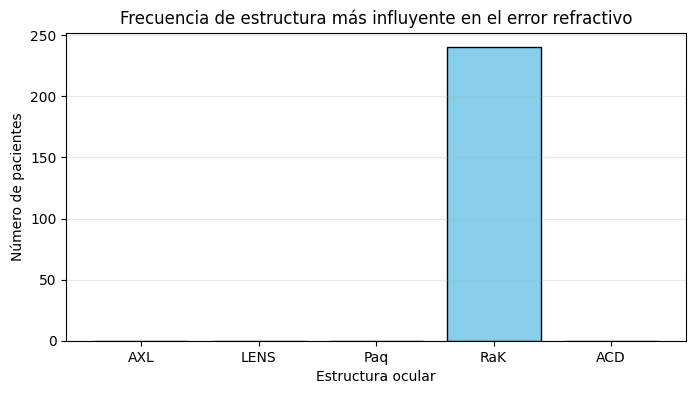

In [37]:
# Cálculo de la sensibilidad local (gradientes) del error refractivo respecto a cada estructura ocular

# Obtener predicciones del modelo sobre el conjunto de test (ya desnormalizadas)
parametros_predichos_tf = tf.convert_to_tensor(parametros_predichos_np, dtype=tf.float32)

# Guardar gradientes para cada paciente
sensibilidades = []

for i in range(parametros_predichos_tf.shape[0]):
    x = tf.Variable(parametros_predichos_tf[i:i+1])
    with tf.GradientTape() as tape:
        tape.watch(x)
        axl, lens, paq, rak, acd = tf.unstack(x, axis=1)
        error = model.calculo_error_refractivo_tensores(axl / 1000, lens / 1000, paq / 1000, rak / 1000, acd / 1000)
    grad = tape.gradient(error, x)
    if grad is not None:
        sensibilidades.append(np.abs(grad.numpy().flatten()))
    else:
        sensibilidades.append(np.zeros(5))

sensibilidades = np.array(sensibilidades)  # shape: (n_pacientes, 5)

# Identificar la estructura más influyente para cada paciente
mas_influyente = np.argmax(sensibilidades, axis=1)

# Mostrar tabla resumen de sensibilidades medias
sens_df = pd.DataFrame(sensibilidades, columns=feature_names)
print('Sensibilidad media (absoluta) del error refractivo respecto a cada estructura en validación:')
display(sens_df.mean().to_frame('Sensibilidad media').T)

# Ejemplo: mostrar para los 5 primeros pacientes la estructura más influyente y los valores de sensibilidad
for idx in range(5):
    print(f"Paciente {idx+1}: estructura más influyente = {feature_names[mas_influyente[idx]]}")
    print(f"  Sensibilidades: {dict(zip(feature_names, sensibilidades[idx]))}")

mas_influyente = np.argmax(sensibilidades, axis=1)

conteo = [np.sum(mas_influyente == i) for i in range(len(feature_names))]

plt.figure(figsize=(8, 4))
plt.bar(feature_names, conteo, color='skyblue', edgecolor='k')
plt.xlabel('Estructura ocular')
plt.ylabel('Número de pacientes')
plt.title('Frecuencia de estructura más influyente en el error refractivo')
plt.grid(axis='y', alpha=0.3)
plt.show()

--------------------------------------------------------
El segundo método realiza el cálculo de la sensibilidad mediante el análisis de sensibilidad local por perturbación. Consiste en modificar ligeramente cada parámetro ocular de cada paciente, recalcular la dioptría y ver cuál provoca el mayor cambio.

--------------------------------------------------------

Sensibilidad media (numérica) del error refractivo respecto a cada estructura en validación:


,AXL,LENS,Paq,RaK,ACD
Sensibilidad media,3.219434,0.080494,0.243035,5.912376,0.764372


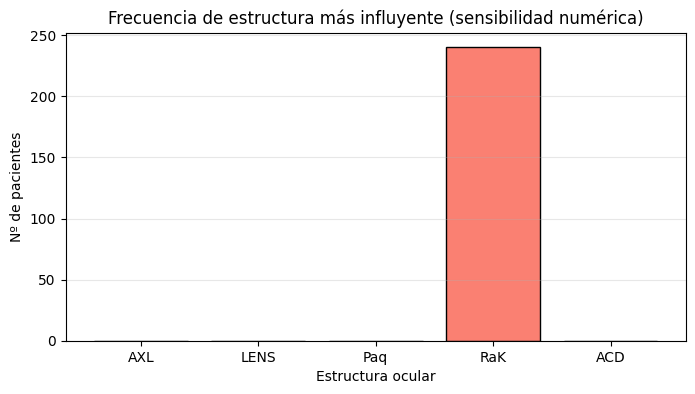

Comparativa (gradiente automático vs. numérico):
AXL: gradiente=0, numérico=0
LENS: gradiente=0, numérico=0
Paq: gradiente=0, numérico=0
RaK: gradiente=240, numérico=240
ACD: gradiente=0, numérico=0


In [38]:
# Análisis de sensibilidad local por perturbación numérica

delta = 0.1  # Perturbación en mm
sensibilidades_num = []

for fila in parametros_predichos_np:
    cambios = []
    for i in range(5):
        params_up = fila.copy()
        params_down = fila.copy()
        params_up[i] += delta
        params_down[i] -= delta
        # Calcula dioptría para +delta y -delta
        d_up = calc(parametros, params_up[0]/1000, params_up[1]/1000, params_up[2]/1000, params_up[3]/1000, params_up[4]/1000)
        d_down = calc(parametros, params_down[0]/1000, params_down[1]/1000, params_down[2]/1000, params_down[3]/1000, params_down[4]/1000)
        # Derivada numérica central
        sensibilidad = np.abs((d_up - d_down) / (2 * delta))
        cambios.append(sensibilidad)
    sensibilidades_num.append(cambios)

sensibilidades_num = np.array(sensibilidades_num)
mas_influyente_num = np.argmax(sensibilidades_num, axis=1)

# Sensibilidad media (método numérico)
sens_num_df = pd.DataFrame(sensibilidades_num, columns=feature_names)
print('Sensibilidad media (numérica) del error refractivo respecto a cada estructura en validación:')
display(sens_num_df.mean().to_frame('Sensibilidad media').T)

# Gráfica de frecuencias
conteo_num = [np.sum(mas_influyente_num == i) for i in range(len(feature_names))]
plt.figure(figsize=(8, 4))
plt.bar(feature_names, conteo_num, color='salmon', edgecolor='k')
plt.xlabel('Estructura ocular')
plt.ylabel('Nº de pacientes')
plt.title('Frecuencia de estructura más influyente (sensibilidad numérica)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Comparativa con gradientes automáticos
print("Comparativa (gradiente automático vs. numérico):")
conteo_grad = [np.sum(np.argmax(sensibilidades, axis=1) == i) for i in range(len(feature_names))]
for i, est in enumerate(feature_names):
    print(f"{est}: gradiente={conteo_grad[i]}, numérico={conteo_num[i]}")

--------------------------------------------------------
La tercera forma se calcula mediante el método de la simulación inversa, donde manteniendo fijas el resto de variables, buscar el parámetro que lleva la la potencia de la lente a 0, es decir, al ojo emétrope.

--------------------------------------------------------

Cambio medio necesario para emetropía (simulación inversa):


,AXL,LENS,Paq,RaK,ACD
Cambio medio necesario,0.475728,1.22121,0.966731,0.260037,0.938386


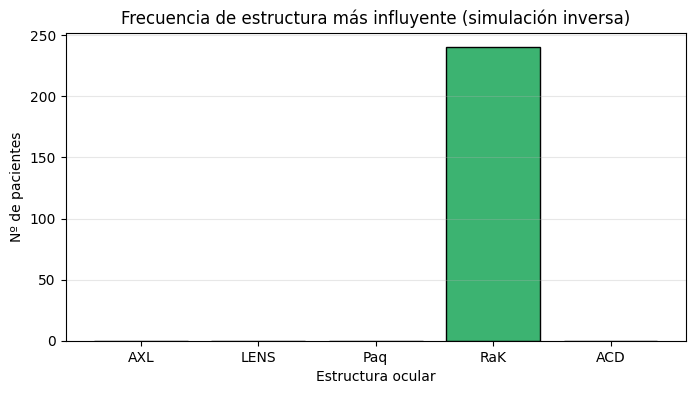

Comparativa (gradiente, numérica, inversa):
AXL: gradiente=0, numérica=0, inversa=0
LENS: gradiente=0, numérica=0, inversa=0
Paq: gradiente=0, numérica=0, inversa=0
RaK: gradiente=240, numérica=240, inversa=240
ACD: gradiente=0, numérica=0, inversa=0


In [39]:
cambios_necesarios = []

for fila in parametros_predichos_np:
    cambios = []
    for i in range(5):
        def f(x):
            params = fila.copy()
            params[i] = x
            return calc(parametros, params[0]/1000, params[1]/1000, params[2]/1000, params[3]/1000, params[4]/1000)
        # Usamos el valor actual +/- 2 mm como intervalo de búsqueda
        x0 = fila[i]
        try:
            sol = root_scalar(f, bracket=[x0-2, x0+2], method='brentq')
            if sol.converged:
                cambios.append(np.abs(sol.root - x0))
            else:
                cambios.append(np.nan)
        except Exception:
            cambios.append(np.nan)
    cambios_necesarios.append(cambios)

cambios_necesarios = np.array(cambios_necesarios)
mas_influyente_inv = np.nanargmin(cambios_necesarios, axis=1)

# Sensibilidad media (simulación inversa)
cambios_inv_df = pd.DataFrame(cambios_necesarios, columns=feature_names)
print('Cambio medio necesario para emetropía (simulación inversa):')
display(cambios_inv_df.mean().to_frame('Cambio medio necesario').T)

# Gráfica de frecuencias
conteo_inv = [np.sum(mas_influyente_inv == i) for i in range(len(feature_names))]
plt.figure(figsize=(8, 4))
plt.bar(feature_names, conteo_inv, color='mediumseagreen', edgecolor='k')
plt.xlabel('Estructura ocular')
plt.ylabel('Nº de pacientes')
plt.title('Frecuencia de estructura más influyente (simulación inversa)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Comparativa con gradientes y sensibilidad numérica
print("Comparativa (gradiente, numérica, inversa):")
conteo_grad = [np.sum(np.argmax(sensibilidades, axis=1) == i) for i in range(len(feature_names))]
conteo_num = [np.sum(mas_influyente_num == i) for i in range(len(feature_names))]
for i, est in enumerate(feature_names):
    print(f"{est}: gradiente={conteo_grad[i]}, numérica={conteo_num[i]}, inversa={conteo_inv[i]}")

--------------------------------------------------------
Como se puede ver, para los 3 casos, la estructura con mayor sensibilidad es el radio anterior de la córnea, el cúal, con desviaciones muy pequeñas modifica en gran cantidad el grado de ametropía del ojo.

### Distancia media teórica
En la siguiente celda se va a mostrar la distancia media entre las diferentes estructuras del ojo y sus valores teóricos según el modelo de LeGrand.

--------------------------------------------------------

Desviación media respecto al valor emétrope (mm):


,AXL,LENS,Paq,RaK,ACD
Desviación media,0.991993,0.640474,0.007448,0.263071,0.465276


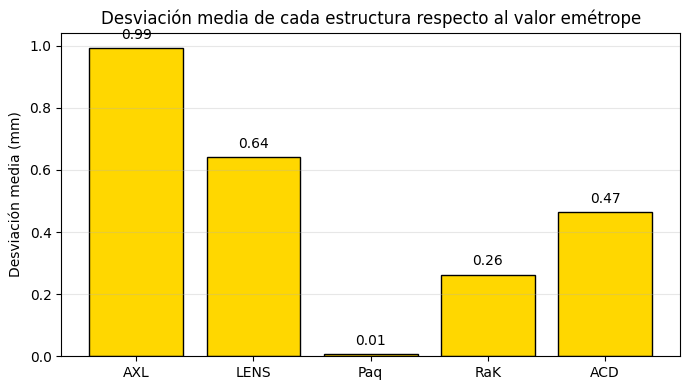

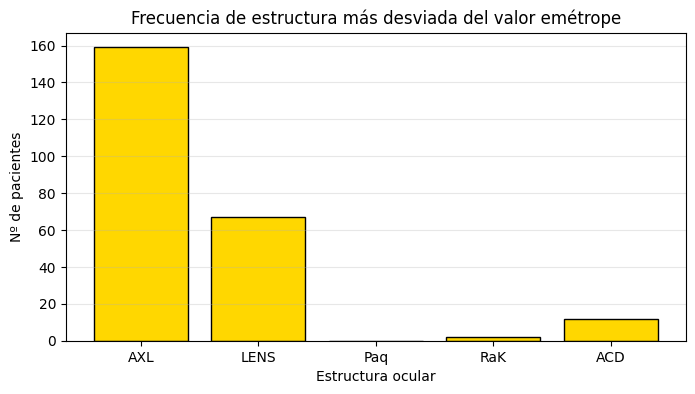

In [40]:
valores_emetro = {
    'AXL': 24,
    'LENS': 4.0,
    'Paq': 0.55,
    'RaK': 7.8,
    'ACD': 3.6
}

desviaciones = []
for fila in parametros_predichos_np:
    desv = [np.abs(fila[i] - valores_emetro[estr]) for i, estr in enumerate(feature_names)]
    desviaciones.append(desv)
desviaciones = np.array(desviaciones)

# 3. Identifica la estructura más desviada para cada paciente
mas_desviado = np.argmax(desviaciones, axis=1)

# 4. Tabla de desviaciones medias
desv_df = pd.DataFrame(desviaciones, columns=feature_names)
print('Desviación media respecto al valor emétrope (mm):')
display(desv_df.mean().to_frame('Desviación media').T)

desviacion_media = desv_df.mean()
plt.figure(figsize=(7, 4))
bars = plt.bar(desviacion_media.index, desviacion_media.values, color='gold', edgecolor='k')
plt.ylabel('Desviación media (mm)')
plt.title('Desviación media de cada estructura respecto al valor emétrope')
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(desviacion_media.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 5. Frecuencia de estructura más desviada
conteo_desv = [np.sum(mas_desviado == i) for i in range(len(feature_names))]
plt.figure(figsize=(8, 4))
plt.bar(feature_names, conteo_desv, color='gold', edgecolor='k')
plt.xlabel('Estructura ocular')
plt.ylabel('Nº de pacientes')
plt.title('Frecuencia de estructura más desviada del valor emétrope')
plt.grid(axis='y', alpha=0.3)
plt.show()

--------------------------------------------------------
Con la siguiente función, a partir de los datos del paciente, se puede extraer los valores de sus estructuras biómetricas y su desviación respecto al ojo emétrope.

--------------------------------------------------------

In [41]:
def estructura_mas_facil_de_corregir(fila_parametros, feature_names=['AXL', 'LENS', 'Paq', 'RaK', 'ACD']):
    """
    Para una fila de parámetros biométricos, calcula el cambio mínimo necesario en cada estructura
    para alcanzar emetropía (dioptría=0), manteniendo fijas las demás.
    Devuelve un dict con los cambios y la estructura más eficiente.
    """
    cambios = []
    for i in range(5):
        def f(x):
            params = fila_parametros.copy()
            params[i] = x
            return calc(parametros, params[0]/1000, params[1]/1000, params[2]/1000, params[3]/1000, params[4]/1000)
        x0 = fila_parametros[i]
        try:
            sol = root_scalar(f, bracket=[x0-2, x0+2], method='brentq')
            if sol.converged:
                cambios.append(np.abs(sol.root - x0))
            else:
                cambios.append(np.nan)
        except Exception:
            cambios.append(np.nan)
    cambios = np.array(cambios)
    idx_min = np.nanargmin(cambios)
    return {
        'cambios_necesarios': dict(zip(feature_names, cambios)),
        'estructura_mas_facil': feature_names[idx_min],
        'cambio_minimo': cambios[idx_min]
    }

--------------------------------------------------------
Con la siguiente función, se puede hacer un resumen detallado para los datos de un paciente, que muestra su predicción biométrica, la desviación de sus estructuras respecto a los valores teóricos de LeGrand y qué estructuras puedes cambiar fijando el resto para llevar el ojo a la emetropía y cuánto deben de cambiar.

--------------------------------------------------------

,AXL,LENS,Paq,RaK,ACD,Más desviada
0,22.174999,4.697,0.545,7.608,2.884,AXL



Desviaciones respecto a emetropía (mm):


,AXL,LENS,Paq,RaK,ACD
0,1.825,0.697,0.005,0.192,0.716


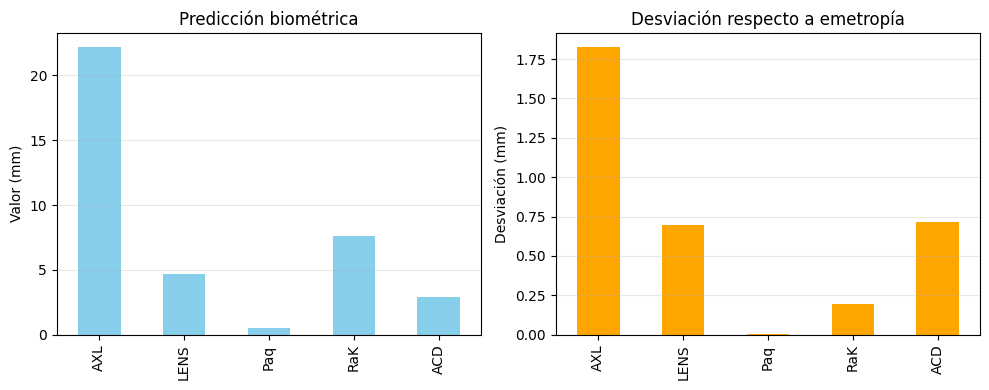

Estructura más desviada: AXL


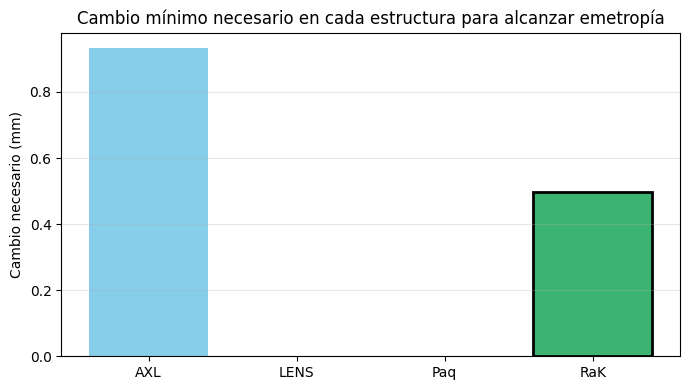

Estructura más eficiente de modificar: RaK (0.498 mm)


In [42]:
def resumen_prediccion_emetropia(model, X_input, feature_names=['AXL', 'LENS', 'Paq', 'RaK', 'ACD']):
    """
    Dada una matriz de entrada (puede ser DataFrame o np.array) con las variables de entrada del modelo,
    predice los parámetros biométricos y devuelve, para cada muestra, la estructura más desviada del valor emétrope.
    """

    # Si es DataFrame, conviértelo a np.array
    if hasattr(X_input, 'values'):
        X_input = X_input.values

    # Normalizar igual que en el entrenamiento
    X_input_norm = (X_input - model.X_mean.numpy()) / model.X_std.numpy()
    X_input_tf = tf.constant(X_input_norm, dtype=tf.float32)

    # Predicción
    y_pred_norm = model(X_input_tf, training=False)
    y_pred = y_pred_norm * model.y_std + model.y_mean
    y_pred_np = y_pred.numpy()

    # Calcular desviaciones respecto a emetropía
    desviaciones = []
    for fila in y_pred_np:
        desv = [np.abs(fila[i] - valores_emetro[estr]) for i, estr in enumerate(feature_names)]
        desviaciones.append(desv)
    desviaciones = np.array(desviaciones)
    mas_desviado = np.argmax(desviaciones, axis=1)

    # Construir resumen
    resumen = []
    for i, fila in enumerate(y_pred_np):
        resultado = {
            'Predicciones': dict(zip(feature_names, fila)),
            'Desviaciones': dict(zip(feature_names, desviaciones[i])),
            'Estructura_mas_desviada': feature_names[mas_desviado[i]]
        }
        resumen.append(resultado)

    return resumen

def mostrar_resumen_emetropia(resumen, feature_names=['AXL', 'LENS', 'Paq', 'RaK', 'ACD']):
    """
    Visualiza el resumen de predicción de emetropía para una o varias muestras.
    Si es una sola muestra, también muestra la gráfica de cambios mínimos para emetropía.
    """
    # Convertir a DataFrame para mejor visualización
    df_pred = pd.DataFrame([r['Predicciones'] for r in resumen])
    df_desv = pd.DataFrame([r['Desviaciones'] for r in resumen])
    estructuras = [r['Estructura_mas_desviada'] for r in resumen]
    df_pred['Más desviada'] = estructuras

    display(df_pred.round(3))
    print("\nDesviaciones respecto a emetropía (mm):")
    display(df_desv.round(3))

    if len(resumen) == 1:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        df_pred.iloc[0][feature_names].plot(kind='bar', ax=ax[0], color='skyblue')
        ax[0].set_title('Predicción biométrica')
        ax[0].set_ylabel('Valor (mm)')
        ax[0].grid(axis='y', alpha=0.3)
        df_desv.iloc[0].plot(kind='bar', ax=ax[1], color='orange')
        ax[1].set_title('Desviación respecto a emetropía')
        ax[1].set_ylabel('Desviación (mm)')
        ax[1].grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        print(f"Estructura más desviada: {estructuras[0]}")

        # --- INTEGRACIÓN DE LA GRÁFICA DE CAMBIOS NECESARIOS ---
        prediccion = resumen[0]['Predicciones']
        fila_parametros = np.array([prediccion[n] for n in feature_names])
        resultado = estructura_mas_facil_de_corregir(fila_parametros, feature_names)
        cambios = resultado['cambios_necesarios']
        estructura_min = resultado['estructura_mas_facil']

        plt.figure(figsize=(7, 4))
        bars = plt.bar(
            cambios.keys(),
            cambios.values(),
            color=['mediumseagreen' if k == estructura_min else 'skyblue' for k in cambios.keys()]
        )
        plt.ylabel('Cambio necesario (mm)')
        plt.title('Cambio mínimo necesario en cada estructura para alcanzar emetropía')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        for bar, key in zip(bars, cambios.keys()):
            if key == estructura_min:
                bar.set_edgecolor('black')
                bar.set_linewidth(2)
        plt.show()
        print(f"Estructura más eficiente de modificar: {estructura_min} ({cambios[estructura_min]:.3f} mm)")
    else:
        # Si son varias muestras, mostrar histograma de la estructura más desviada
        plt.figure(figsize=(6, 4))
        pd.Series(estructuras).value_counts().reindex(feature_names, fill_value=0).plot(kind='bar', color='gold', edgecolor='k')
        plt.title('Frecuencia de estructura más desviada')
        plt.xlabel('Estructura')
        plt.ylabel('Nº de muestras')
        plt.grid(axis='y', alpha=0.3)
        plt.show()

resumen = resumen_prediccion_emetropia(model, np.expand_dims(X_test[0], axis=0))
mostrar_resumen_emetropia(resumen)

--------------------------------------------------------

También se puede visualizar, para un paciente, cuáles son las tres mejores alteraciones de sus estructuras oculares que permiten llevar al ojo a la emetropía, es decir, las tres combinaciones que implican el menor cambio de las estructuras.

--------------------------------------------------------

In [43]:
# Visualización de la solución óptima emétrope
def mostrar_solucion_emetrope(parametros_actuales, resultado, feature_names=['AXL', 'LENS', 'Paq', 'RaK', 'ACD']):
    if resultado is None:
        print("No se encontró solución emétrope.")
        return

    actuales = np.array(parametros_actuales, dtype=np.float64)
    emetrope = np.array(resultado['parametros_emetrope'], dtype=np.float64)
    diferencias = emetrope - actuales

    df = pd.DataFrame({
        'Actual': actuales,
        'Emétrope óptimo': emetrope,
        'Cambio necesario': diferencias
    }, index=feature_names)
    display(df.round(3))

    # Gráfica de barras de los cambios necesarios
    plt.figure(figsize=(8, 4))
    bars = plt.bar(feature_names, diferencias, color='mediumseagreen')
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel('Cambio necesario (mm)')
    plt.title('Cambio necesario en cada parámetro para emetropía')
    plt.grid(axis='y', alpha=0.3)
    # Resalta el cambio mayor
    idx_max = np.argmax(np.abs(diferencias))
    bars[idx_max].set_edgecolor('black')
    bars[idx_max].set_linewidth(2)
    plt.tight_layout()
    plt.show()

    print(f"Distancia total movida en el espacio de parámetros: {resultado['distancia_total']:.3f} mm")


Solución #1:


,Actual,Emétrope óptimo,Cambio necesario
AXL,22.512,22.467,-0.045
LENS,4.859,4.860,0.001
Paq,0.546,0.543,-0.003
RaK,7.146,7.231,0.085
ACD,3.120,3.131,0.010


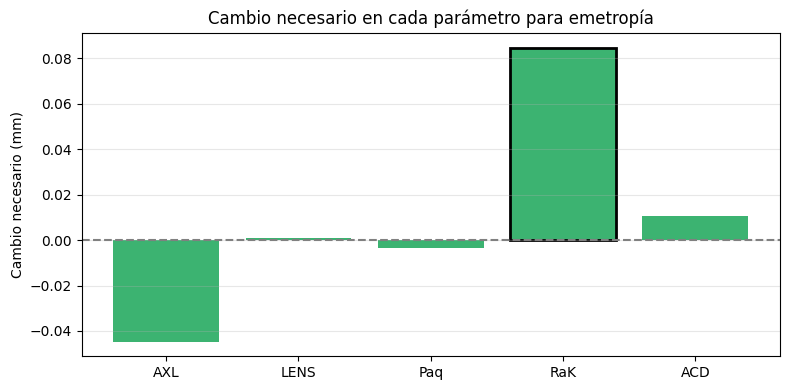

Distancia total movida en el espacio de parámetros: 0.096 mm


In [44]:
def encontrar_top_parametros_emetrope(parametros_actuales, parametros, n_soluciones=3, tol=1e-4, max_iter=1000):
    """
    Busca las n combinaciones de parámetros biométricos más cercanas a los actuales
    que hagan que el ojo sea emétrope (dioptría=0), usando diferentes puntos de partida.
    Devuelve una lista de soluciones ordenadas por distancia total movida.
    """
    parametros_actuales = parametros_actuales.astype(np.float64)
    soluciones = []

    # Genera puntos de partida: actual, +/- 1mm en cada parámetro
    seeds = [parametros_actuales]
    for i in range(len(parametros_actuales)):
        for delta in [-1, 1]:
            seed = parametros_actuales.copy()
            seed[i] += delta
            seeds.append(seed)

    for x0 in seeds:
        def objetivo(x):
            return np.sum((x - parametros_actuales)**2)
        def restriccion(x):
            return calc(parametros, x[0]/1000, x[1]/1000, x[2]/1000, x[3]/1000, x[4]/1000)
        cons = {'type': 'eq', 'fun': restriccion}
        res = minimize(objetivo, x0, constraints=cons, tol=tol, options={'maxiter': max_iter})
        if res.success:
            # Evita duplicados (por tolerancia numérica)
            ya_existe = any(np.allclose(res.x, s['parametros_emetrope'], atol=1e-3) for s in soluciones)
            if not ya_existe:
                soluciones.append({
                    'parametros_emetrope': res.x,
                    'distancia_total': np.linalg.norm(res.x - parametros_actuales),
                    'diferencias': res.x - parametros_actuales
                })

    # Ordena por distancia total movida
    soluciones = sorted(soluciones, key=lambda s: s['distancia_total'])
    return soluciones[:n_soluciones]


top_resultados = encontrar_top_parametros_emetrope(fila, parametros, n_soluciones=3)
for i, res in enumerate(top_resultados, 1):
    print(f"\nSolución #{i}:")
    mostrar_solucion_emetrope(fila, res)

--------------------------------------------------------
Por último, para cada paciente, podemos ver el porcentaje de influencia de cada estructura ocular en la ametropía.

--------------------------------------------------------

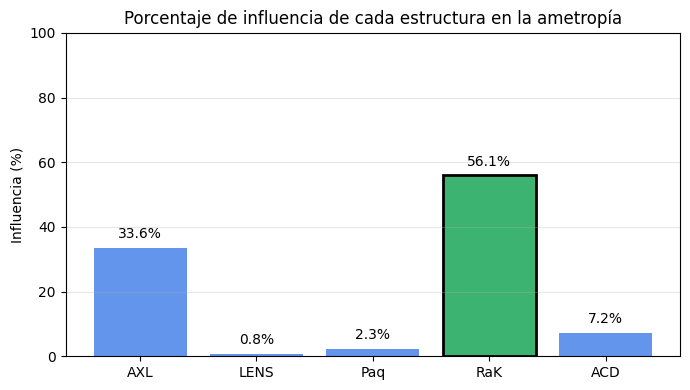

Estructura más influyente: RaK (56.1%)


{'AXL': np.float32(33.620327),
 'LENS': np.float32(0.772822),
 'Paq': np.float32(2.3047822),
 'RaK': np.float32(56.053818),
 'ACD': np.float32(7.248254)}

In [45]:
def porcentaje_influencia_estructuras(model, parametros_paciente, feature_names=['AXL', 'LENS', 'Paq', 'RaK', 'ACD'], show_plot=True):
    """
    Calcula y muestra el porcentaje de influencia de cada estructura ocular en la ametropía
    para un paciente dado (vector de 5 parámetros biométricos en mm).
    Devuelve un diccionario con los porcentajes.
    """
    # Asegura que sea tensor y tenga la forma correcta
    x = tf.Variable(parametros_paciente.reshape(1, -1), dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        axl, lens, paq, rak, acd = tf.unstack(x, axis=1)
        error = model.calculo_error_refractivo_tensores(axl / 1000, lens / 1000, paq / 1000, rak / 1000, acd / 1000)
    grad = tape.gradient(error, x)
    grad_abs = np.abs(grad.numpy().flatten())
    suma = grad_abs.sum()
    if suma == 0:
        porcentajes = np.zeros_like(grad_abs)
    else:
        porcentajes = 100 * grad_abs / suma
    resultado = dict(zip(feature_names, porcentajes))

    if show_plot:
        plt.figure(figsize=(7, 4))
        bars = plt.bar(feature_names, porcentajes, color='cornflowerblue')
        plt.ylabel('Influencia (%)')
        plt.title('Porcentaje de influencia de cada estructura en la ametropía')
        plt.ylim(0, 100)
        plt.grid(axis='y', alpha=0.3)
        idx_max = np.argmax(porcentajes)
        bars[idx_max].set_color('mediumseagreen')
        bars[idx_max].set_edgecolor('black')
        bars[idx_max].set_linewidth(2)
        for i, v in enumerate(porcentajes):
            plt.text(i, v + 2, f"{v:.1f}%", ha='center', va='bottom', fontsize=10)
        plt.tight_layout()
        plt.show()
        print(f"Estructura más influyente: {feature_names[idx_max]} ({porcentajes[idx_max]:.1f}%)")
    return resultado

paciente = parametros_predichos_np[0]
porcentaje_influencia_estructuras(model, paciente)

Porcentaje de influencia promedio de cada estructura en el conjunto de test:


,AXL,LENS,Paq,RaK,ACD
Influencia promedio (%),31.491659,0.790536,2.378447,57.844433,7.494925


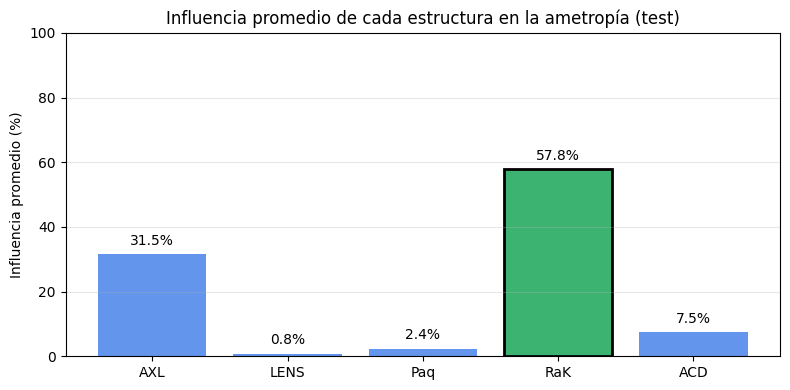

In [46]:
# Calcular el porcentaje de influencia para cada paciente
porcentajes_todos = []
for paciente in parametros_predichos_np:
    porcentajes = porcentaje_influencia_estructuras(model, paciente, show_plot=False)
    porcentajes_todos.append(list(porcentajes.values()))

# Convertir a DataFrame para análisis
df_porcentajes = pd.DataFrame(porcentajes_todos, columns=feature_names)

# Calcular el promedio por estructura
promedio_por_estructura = df_porcentajes.mean()

print("Porcentaje de influencia promedio de cada estructura en el conjunto de test:")
display(promedio_por_estructura.to_frame('Influencia promedio (%)').T)

# Gráfico de barras
plt.figure(figsize=(8, 4))
bars = plt.bar(promedio_por_estructura.index, promedio_por_estructura.values, color='cornflowerblue')
plt.ylabel('Influencia promedio (%)')
plt.title('Influencia promedio de cada estructura en la ametropía (test)')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
idx_max = np.argmax(promedio_por_estructura.values)
bars[idx_max].set_color('mediumseagreen')
bars[idx_max].set_edgecolor('black')
bars[idx_max].set_linewidth(2)
for i, v in enumerate(promedio_por_estructura.values):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

--------------------------------------------------------

**Clusterización con datos de test.**

--------------------------------------------------------

In [47]:
#Coger solo valores con dioptrias menores que 0
mascara = X_test[:, -1] <= 0

X_test_filtrado = X_test[mascara]
y_test_filtrado = y_test[mascara] if isinstance(y_test, np.ndarray) else y_test.numpy()[mascara]

# Normalizar X_test con la media y std del entrenamiento
X_test_norm = (X_test_filtrado - model.X_mean.numpy()) / model.X_std.numpy()
X_test_norm_tf = tf.constant(X_test_norm, dtype=tf.float32)

# Predicción sobre test filtrado
y_pred_norm = model(X_test_norm_tf, training=False)
y_pred = y_pred_norm * model.y_std + model.y_mean
y_pred_np = y_pred.numpy()

print("Número de predicciones (datos de test):", y_pred_np.shape[0])


inertias = []
silhouette_scores = []

cluster_range = range(2, 21)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(y_pred_np)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(y_pred_np, kmeans.labels_)
    silhouette_scores.append(score)




Número de predicciones (datos de test): 124


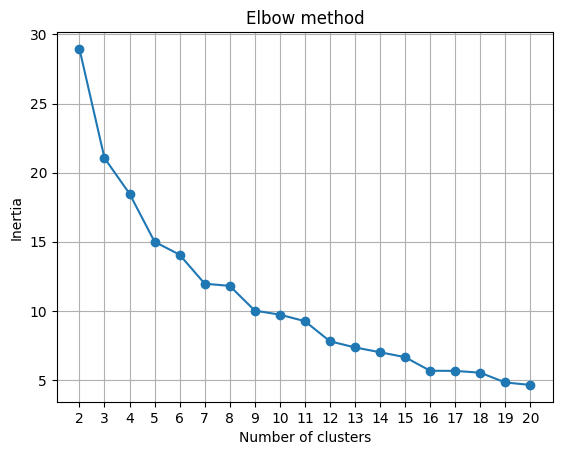

In [48]:
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

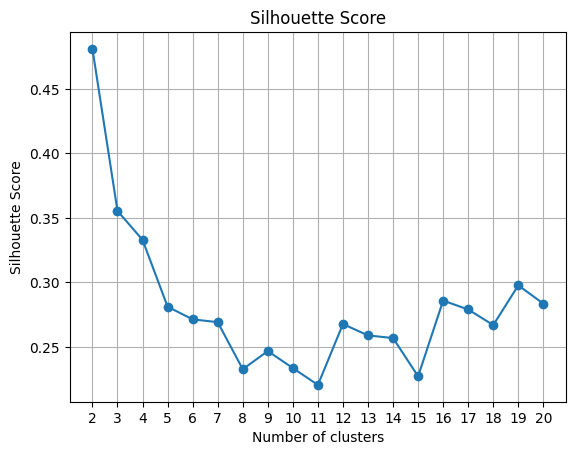

In [49]:
# Gráfico de silhouette
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [50]:
from mpl_toolkits.mplot3d import Axes3D

tsne2 = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
y_pred_tsne2 = tsne2.fit_transform(y_pred_np)

tsne3 = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
y_pred_tsne3 = tsne3.fit_transform(y_pred_np)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(y_pred_np)



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


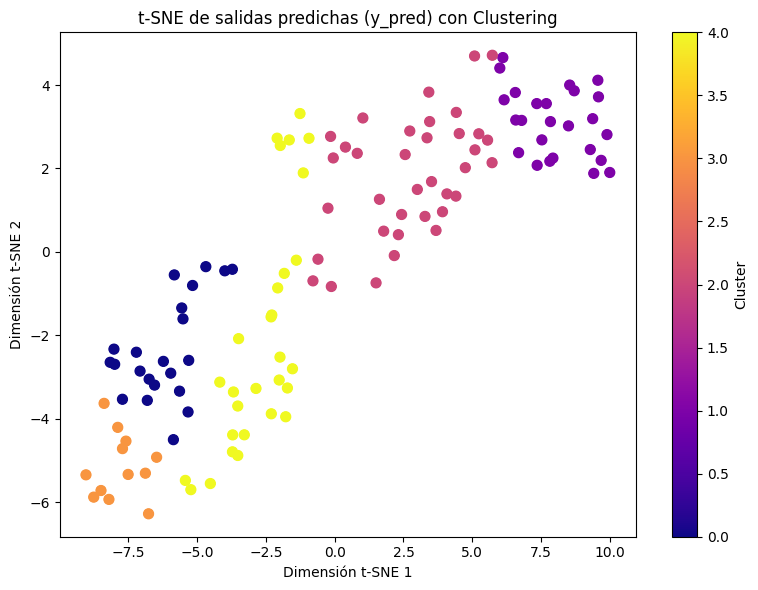

In [51]:
# Visualización 3D
plt.figure(figsize=(8, 6))


plt.scatter(
    y_pred_tsne2[:, 0],
    y_pred_tsne2[:, 1],
    c=clusters, cmap='plasma', s=50
)

plt.scatter(y_pred_tsne2[:, 0], y_pred_tsne2[:, 1], c=clusters, cmap='plasma', s=40)
plt.title('t-SNE de salidas predichas (y_pred) con Clustering')
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

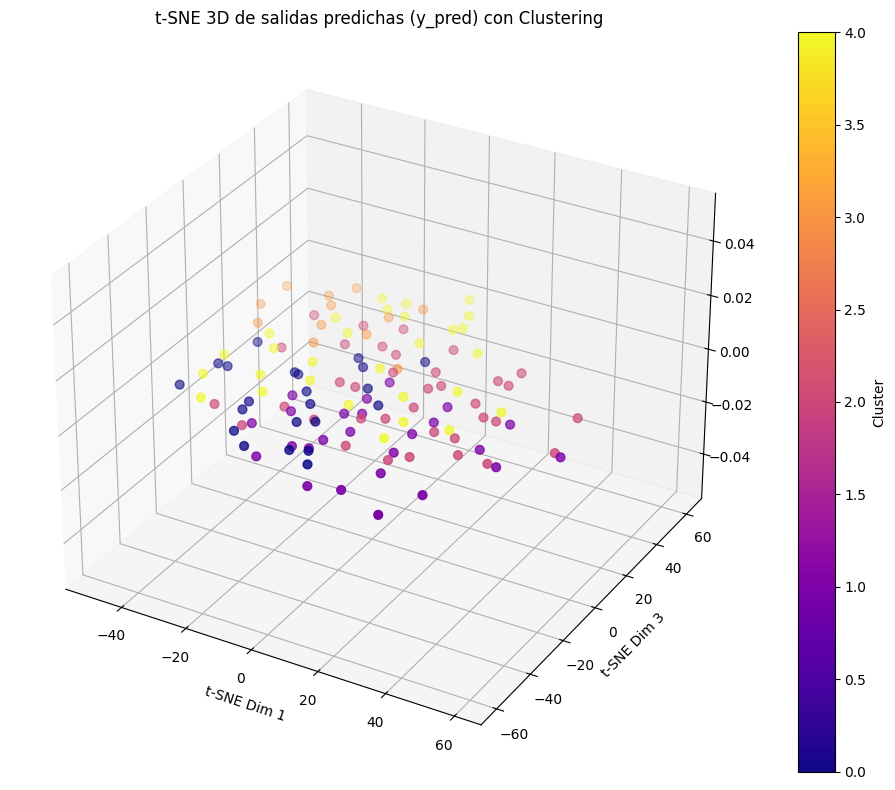

In [52]:
# Visualización 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    y_pred_tsne3[:, 0],
    y_pred_tsne3[:, 1],
    c=clusters, cmap='plasma', s=40
)

ax.set_title('t-SNE 3D de salidas predichas (y_pred) con Clustering')
ax.set_xlabel('t-SNE Dim 1')
ax.set_ylabel('t-SNE Dim 2')
ax.set_ylabel('t-SNE Dim 3')

plt.colorbar(sc, label='Cluster')
plt.tight_layout()
plt.show()

Clusterizacion con todos los datos limpiados

In [53]:
# 1. Unir todos los datos de entrada
X_all = np.concatenate([X_train, X_val, X_test], axis=0)

# 2. Filtrar solo filas donde el último valor sea <= 0
mascara = X_all[:, -1] <= 0
X_all_filtrado = X_all[mascara]

# 3. Normalizar con la media y std del entrenamiento
X_all_norm = (X_all_filtrado - model.X_mean.numpy()) / model.X_std.numpy()
X_all_norm_tf = tf.constant(X_all_norm, dtype=tf.float32)

# 4. Predecir usando el modelo PINN
y_pred_norm = model(X_all_norm_tf, training=False)
y_pred = y_pred_norm * model.y_std + model.y_mean
y_pred_np = y_pred.numpy()

print("Número total de predicciones tras filtrar:", y_pred_np.shape[0])



Número total de predicciones tras filtrar: 622


In [54]:
inertias = []
silhouette_scores = []

cluster_range = range(2, 21)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(y_pred_np)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(y_pred_np, kmeans.labels_)
    silhouette_scores.append(score)

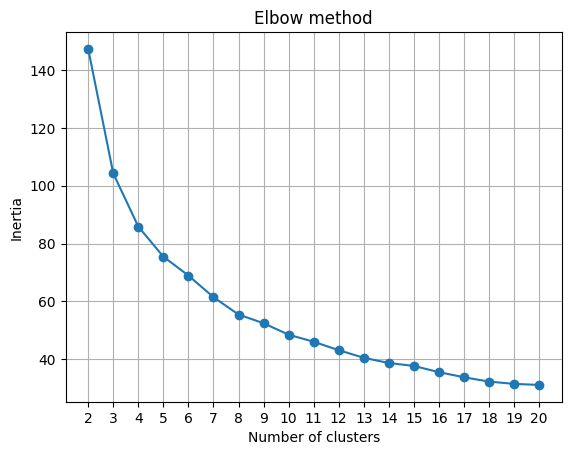

In [55]:
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

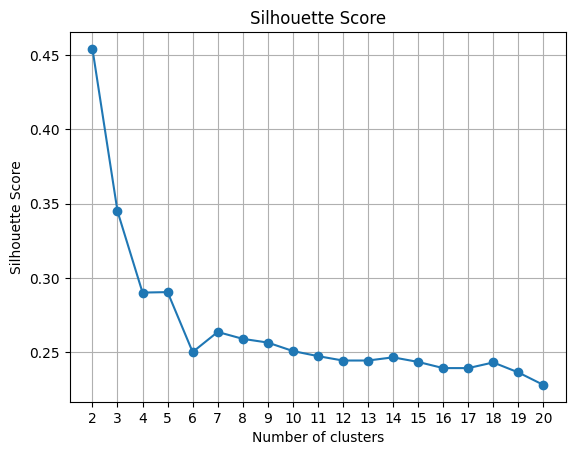

In [56]:
# Gráfico de silhouette
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [57]:
from mpl_toolkits.mplot3d import Axes3D

tsne2 = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
y_pred_tsne2 = tsne2.fit_transform(y_pred_np)

tsne3 = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
y_pred_tsne3 = tsne3.fit_transform(y_pred_np)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(y_pred_np)



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


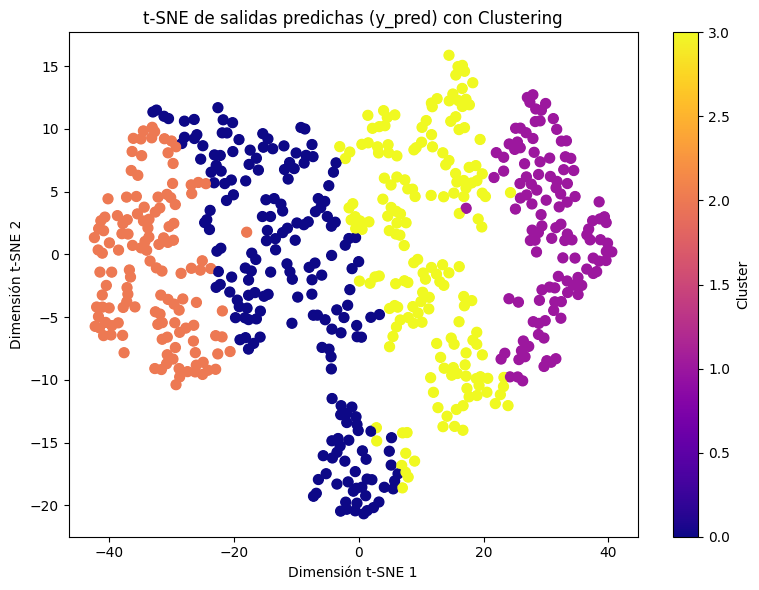

In [58]:
# Visualización 3D
plt.figure(figsize=(8, 6))


plt.scatter(
    y_pred_tsne2[:, 0],
    y_pred_tsne2[:, 1],
    c=clusters, cmap='plasma', s=50
)

plt.scatter(y_pred_tsne2[:, 0], y_pred_tsne2[:, 1], c=clusters, cmap='plasma', s=40)
plt.title('t-SNE de salidas predichas (y_pred) con Clustering')
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

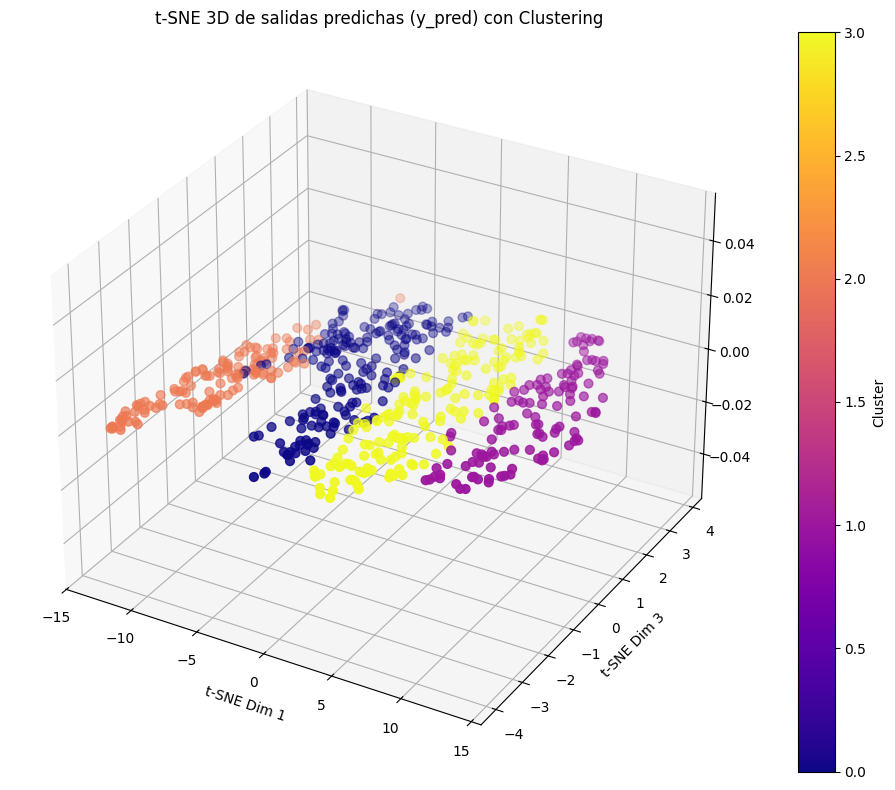

In [59]:
# Visualización 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    y_pred_tsne3[:, 0],
    y_pred_tsne3[:, 1],
    c=clusters, cmap='plasma', s=40
)

ax.set_title('t-SNE 3D de salidas predichas (y_pred) con Clustering')
ax.set_xlabel('t-SNE Dim 1')
ax.set_ylabel('t-SNE Dim 2')
ax.set_ylabel('t-SNE Dim 3')

plt.colorbar(sc, label='Cluster')
plt.tight_layout()
plt.show()

Clusterizacion con datos antes de eliminar outliers

In [60]:
# 1. Unir todos los datos de entrada
X = not_cleaned_data[parametros_entrada].values
y = not_cleaned_data[parametros_target].values

# 2. Filtrar solo filas donde el último valor sea <= 0
mascara = X[:, -1] <= 0
X_all_filtrado = X[mascara]

# 3. Normalizar con la media y std del entrenamiento
X_all_norm = (X_all_filtrado - model.X_mean.numpy()) / model.X_std.numpy()
X_all_norm_tf = tf.constant(X_all_norm, dtype=tf.float32)

# 4. Predecir usando el modelo PINN
y_pred_norm = model(X_all_norm_tf, training=False)
y_pred = y_pred_norm * model.y_std + model.y_mean
y_pred_np = y_pred.numpy()

print("Número total de predicciones tras filtrar:", y_pred_np.shape[0])



Número total de predicciones tras filtrar: 837


In [61]:
inertias = []
silhouette_scores = []

cluster_range = range(2, 21)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(y_pred_np)
    inertias.append(kmeans.inertia_)
    score = silhouette_score(y_pred_np, kmeans.labels_)
    silhouette_scores.append(score)

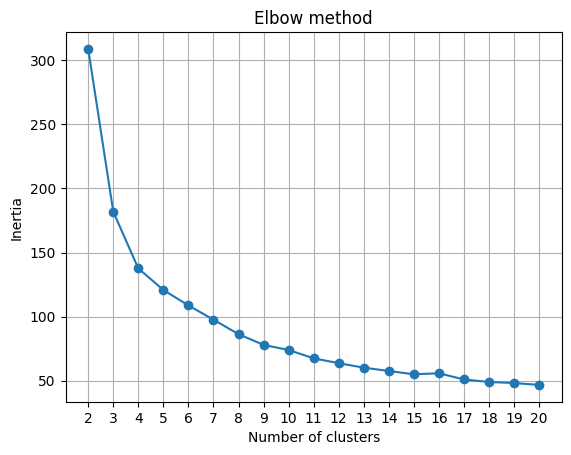

In [62]:
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

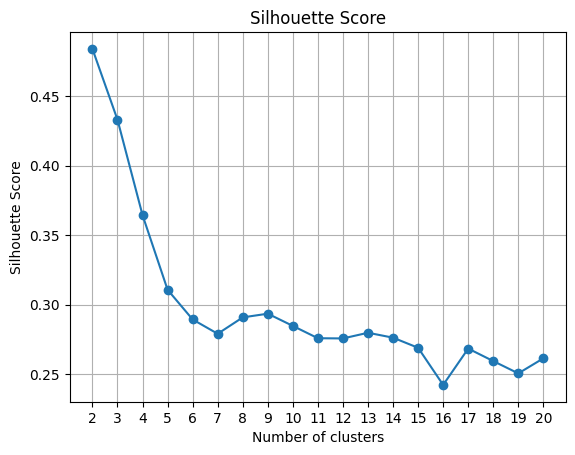

In [63]:
# Gráfico de silhouette
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [64]:
from mpl_toolkits.mplot3d import Axes3D

tsne2 = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
y_pred_tsne2 = tsne2.fit_transform(y_pred_np)

tsne3 = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=1000)
y_pred_tsne3 = tsne3.fit_transform(y_pred_np)

kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(y_pred_np)



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


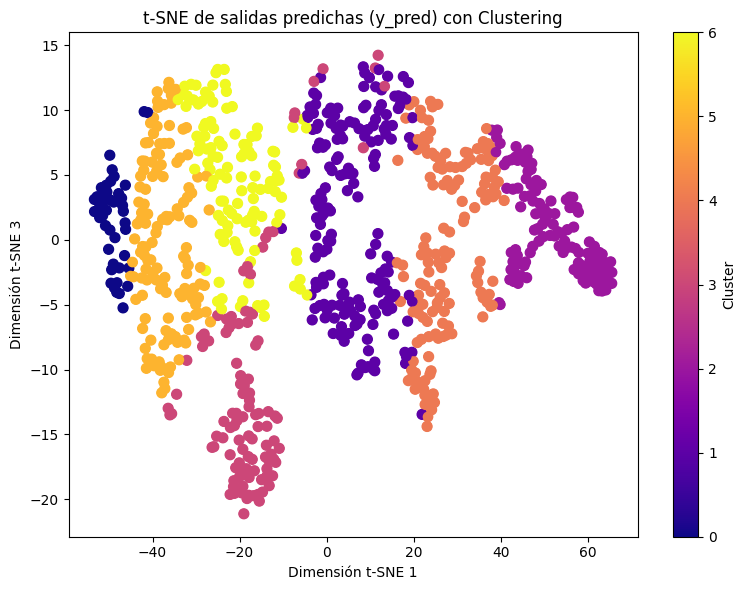

In [65]:
# Visualización 3D
plt.figure(figsize=(8, 6))


plt.scatter(
    y_pred_tsne2[:, 0],
    y_pred_tsne2[:, 1],
    c=clusters, cmap='plasma', s=50
)

plt.scatter(y_pred_tsne2[:, 0], y_pred_tsne2[:, 1], c=clusters, cmap='plasma', s=40)
plt.title('t-SNE de salidas predichas (y_pred) con Clustering')
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.ylabel('Dimensión t-SNE 3')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

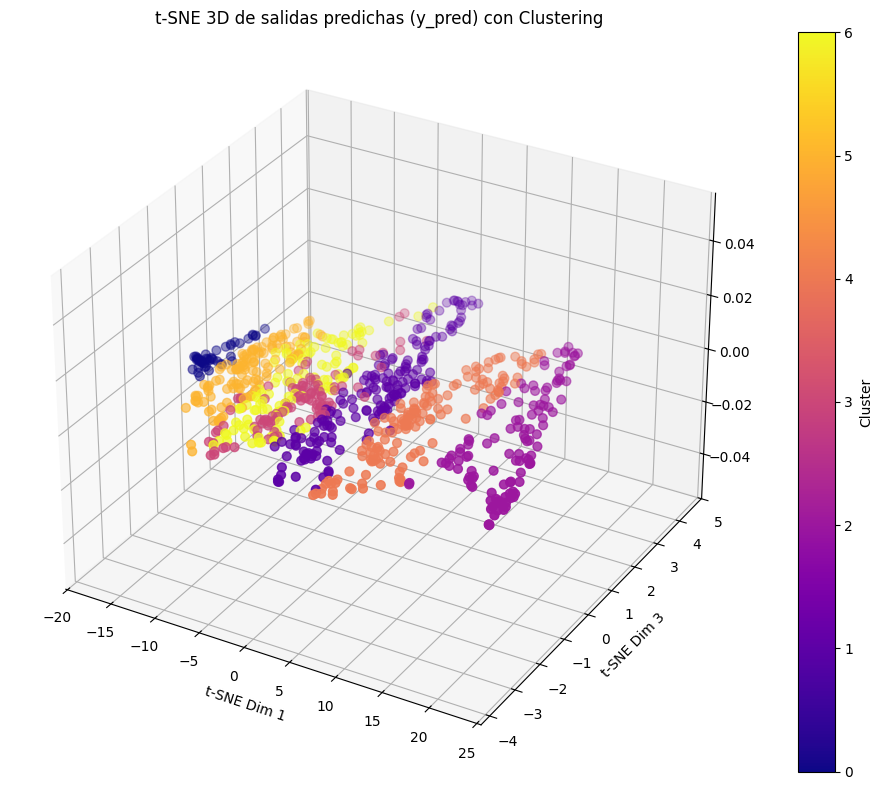

In [66]:
# Visualización 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    y_pred_tsne3[:, 0],
    y_pred_tsne3[:, 1],
    c=clusters, cmap='plasma', s=40
)

ax.set_title('t-SNE 3D de salidas predichas (y_pred) con Clustering')
ax.set_xlabel('t-SNE Dim 1')
ax.set_ylabel('t-SNE Dim 2')
ax.set_ylabel('t-SNE Dim 3')

plt.colorbar(sc, label='Cluster')
plt.tight_layout()
plt.show()